# Assignment 8: Score-based Generative Models

## Submitted By: Aarathi Vijayachandran (244267)

### Assignment question is available here: https://ovgu-ailab.github.io/lgm2024/assignment8.html

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
batch_size = 512
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = np.pad(train_images[..., None], ((0, 0), (2, 2), (2, 2), (0, 0))).astype(np.float32) / 255.
test_images = np.pad(test_images[..., None], ((0, 0), (2, 2), (2, 2), (0, 0))).astype(np.float32) / 255.
train_data = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size, drop_remainder=True)
test_data = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)

11490434/11490434 [==============================] - 2s 0us/step


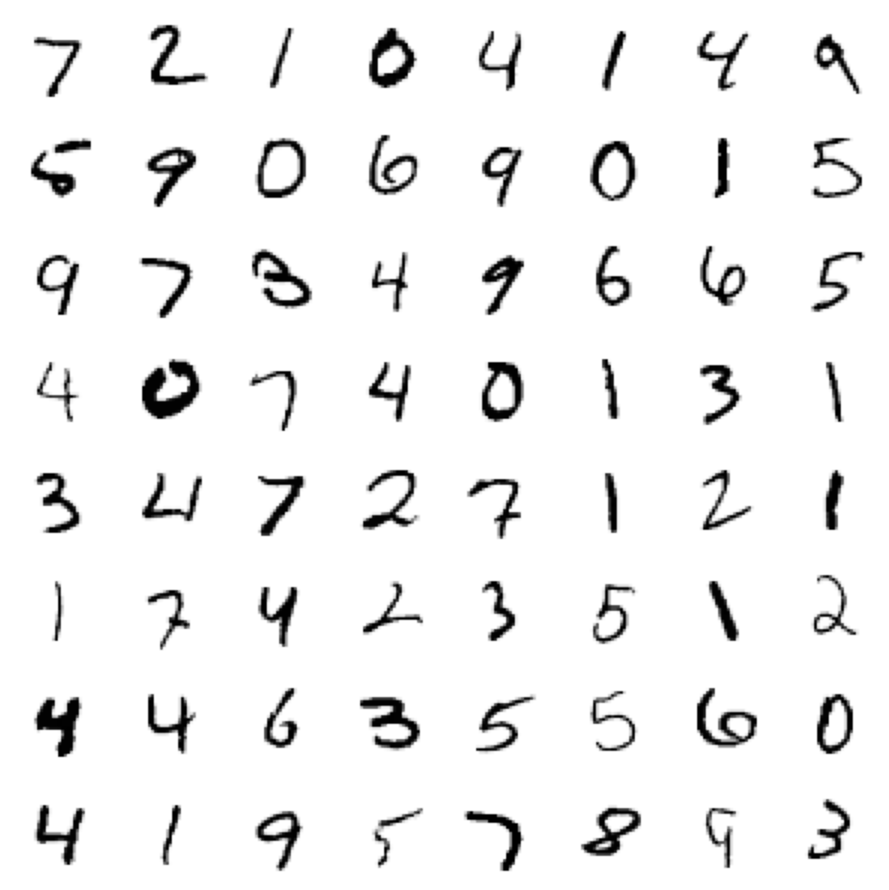

In [3]:
# Plot test images
plt.figure(figsize=(9,9))
for ind, img in enumerate(test_images[:64]):
    plt.subplot(8, 8, ind+1)
    plt.imshow(img, vmin=0, vmax=1, cmap="Greys")
    plt.axis("off")
plt.tight_layout()
plt.show()

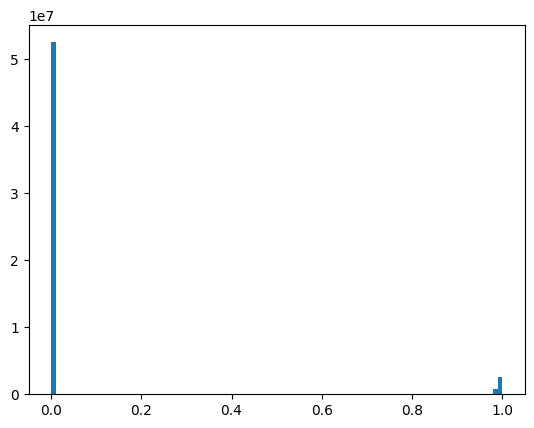

In [4]:
# Plot histogram of the training images
plt.hist(train_images.reshape(-1), bins=100)
plt.show()

In [5]:
# Define noise scales using geometric progression
noise_scales = np.geomspace(1, 0.01, 10)

In [6]:
# Calculate maximum euclidean distance between data points for better noise scale tuning
train_images_flat = test_images.reshape((-1, 32*32))
max_distance_so_far = 0.
_batchsize = 64
for ind in range(0, len(train_images_flat), _batchsize):
    img = train_images_flat[ind:ind+_batchsize]
    all_distances = np.sqrt(np.sum((train_images_flat[None] - img[:, None])**2, axis=-1))
    max_distance_here = all_distances.max()
    max_distance_so_far = np.maximum(max_distance_here, max_distance_so_far)
    if not ind % 10:
        print(ind, max_distance_so_far)

0 15.56643295288086
320 15.823641777038574
640 15.823641777038574
960 15.823641777038574
1280 15.823641777038574
1600 15.823641777038574
1920 15.823641777038574
2240 15.971109390258789
2560 15.971109390258789
2880 15.971109390258789
3200 15.971109390258789
3520 15.971109390258789
3840 15.971109390258789
4160 15.971109390258789
4480 15.971109390258789
4800 15.971109390258789
5120 15.971109390258789
5440 15.971109390258789
5760 15.971109390258789
6080 16.070396423339844
6400 16.070396423339844
6720 16.070396423339844
7040 16.070396423339844
7360 16.070396423339844
7680 16.070396423339844
8000 16.070396423339844
8320 16.070396423339844
8640 16.070396423339844
8960 16.070396423339844
9280 16.070396423339844
9600 16.070396423339844
9920 16.070396423339844


In [7]:
# Define lowest sigma
lowest_sigma = 0.1  # too high!!

In [8]:
# Add noise to test images
noisy_test_images = np.concatenate([batch for batch in iter(test_data)], axis=0) + lowest_sigma * np.random.normal(size=test_images.shape)

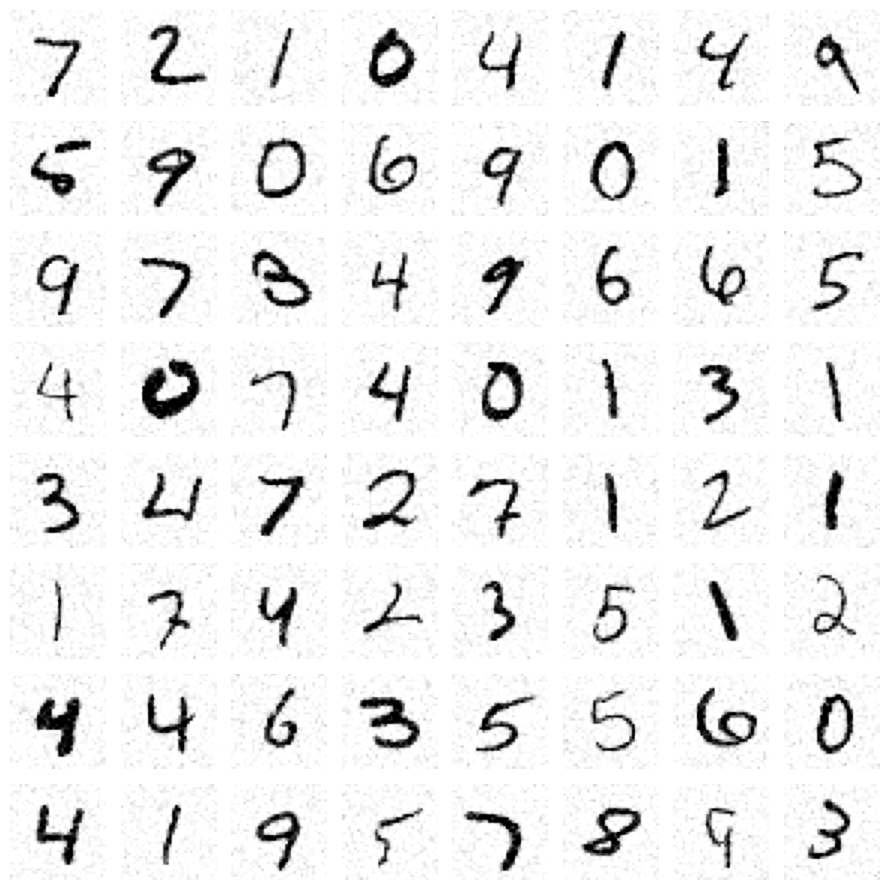

In [9]:
# Plot noisy test images
plt.figure(figsize=(9,9))
for ind, img in enumerate(noisy_test_images[:64]):
    plt.subplot(8, 8, ind+1)
    plt.imshow(img, vmin=0, vmax=1, cmap="Greys")
    plt.axis("off")
plt.tight_layout()
plt.show()

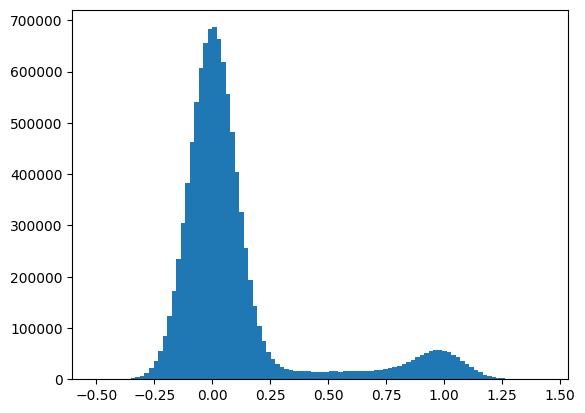

In [10]:
# Plot histogram of noisy test images
plt.hist(noisy_test_images.reshape(-1), bins=100)
plt.show()

In [11]:
# Calculate gamma value
d = 32*32  # data dimensionality
desired_gamma = 1.5  # target ratio between successive noise scales
upper_limit = np.sqrt(2*d) * (desired_gamma - 1) + 3*desired_gamma
lower_limit = np.sqrt(2*d) * (desired_gamma - 1) - 3*desired_gamma
c_value = stats.norm.cdf(upper_limit) - stats.norm.cdf(lower_limit)
print("C value is {}; should be 0.5 or higher (best if close to 1)! Too low? Make gamma smaller!".format(c_value))

C value is 0.0; should be 0.5 or higher (best if close to 1)! Too low? Make gamma smaller!


In [12]:
# Generate noise scales
n_noise_scales = 10
target_noise = 0.01
noise_scales = np.geomspace(max_distance_so_far, target_noise, n_noise_scales, dtype=np.float32)
true_gamma = noise_scales[0] / noise_scales[1]
print("Gamma is {}, should be {} or lower! Too high? Make n_noise_scales larger!".format(true_gamma, desired_gamma))
noise_scales

Gamma is 2.2710421085357666, should be 1.5 or lower! Too high? Make n_noise_scales larger!


array([1.6070396e+01, 7.0762215e+00, 3.1158478e+00, 1.3719903e+00,
       6.0412371e-01, 2.6601169e-01, 1.1713199e-01, 5.1576320e-02,
       2.2710420e-02, 9.9999998e-03], dtype=float32)

In [13]:
# Define the epsilon value for Langevin sampler
def crazy_formula_from_paper(gamma, t, eps):
    final_sig_sq = noise_scales[-1]**2
    first = (1 - (eps / final_sig_sq))**(2*t)
    second = gamma**2 - 2*eps / (final_sig_sq - final_sig_sq * (1 - eps/final_sig_sq)**2)
    third = 2*eps / (final_sig_sq - final_sig_sq * (1 - eps/final_sig_sq)**2)
    return first*second + third

In [14]:
t_total = 500
t_per_noise_scale = t_total // n_noise_scales
epsilon = 0.000001
some_value = crazy_formula_from_paper(true_gamma, t_per_noise_scale, epsilon)
print("The thingy value is {}! It should be close to 1! Try playing around with the epsilon value.".format(some_value))
print("Steps per noise scale:", t_per_noise_scale)

The thingy value is 2.5250135684579265! It should be close to 1! Try playing around with the epsilon value.
Steps per noise scale: 50


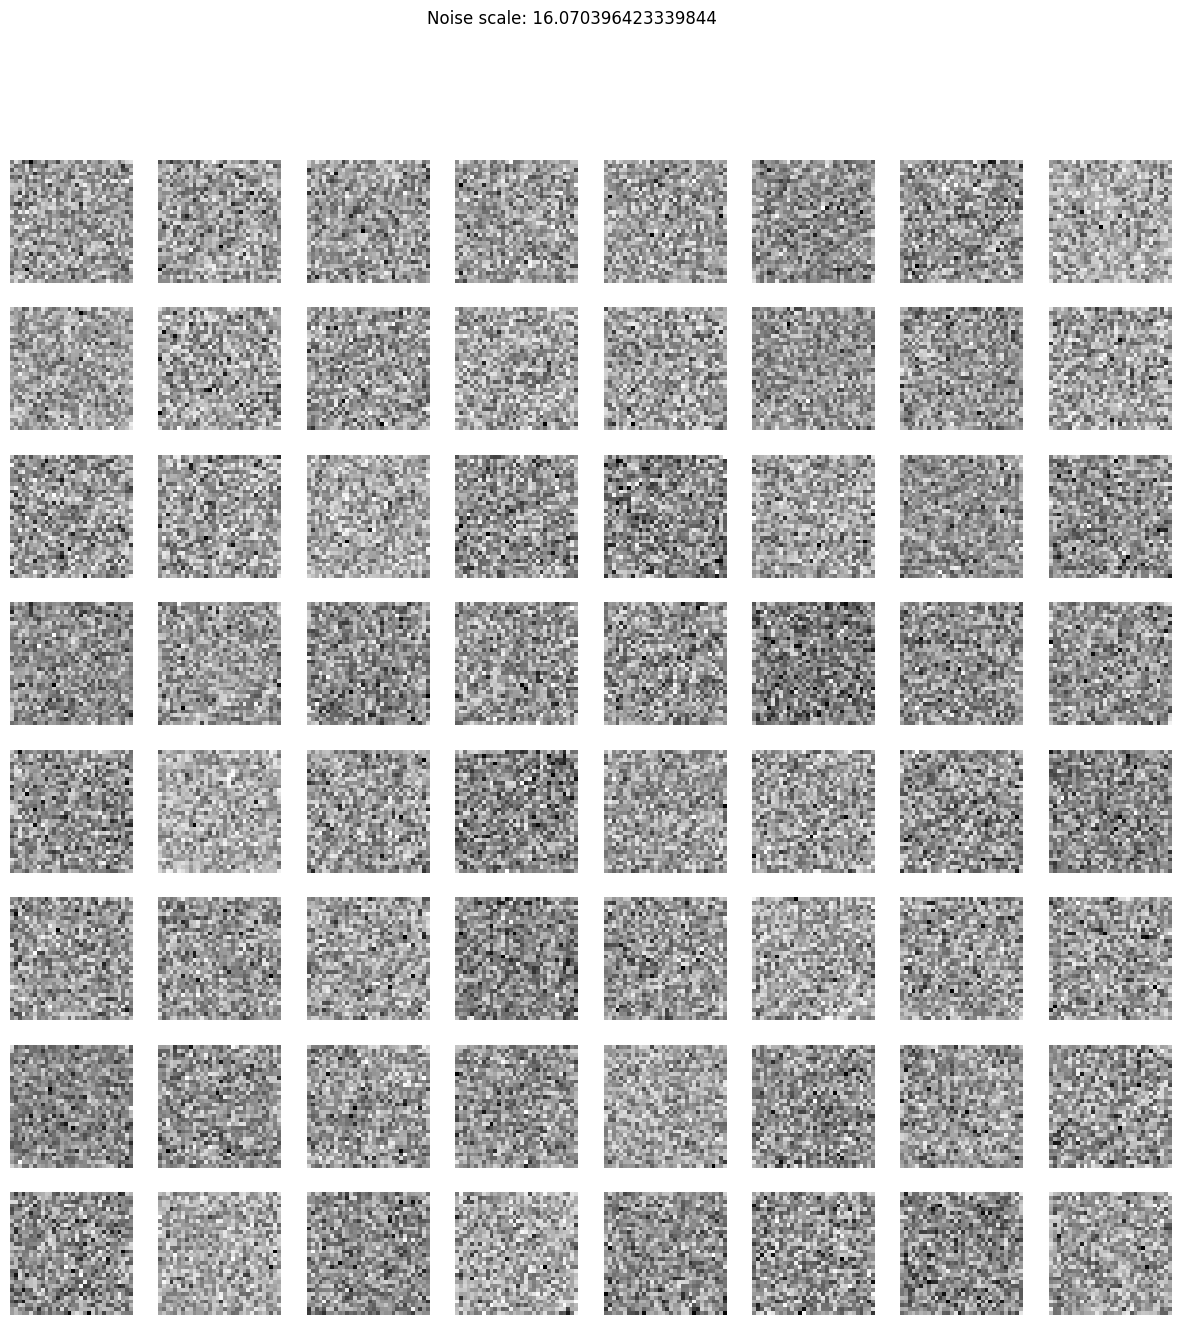

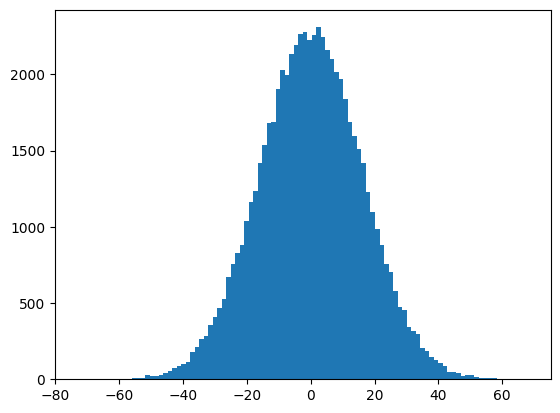

In [15]:
# Plot noisy images at different noise scales
for scale in noise_scales[::20]:
    noisy_imgs = train_images[:64] + scale*np.random.normal(size=(64, 32, 32, 1))
    plt.figure(figsize=(15, 15))
    for ind, image in enumerate(noisy_imgs):
        plt.subplot(8, 8, ind+1)
        plt.imshow(image, cmap="Greys")
        plt.axis("off")
        plt.suptitle("Noise scale: {}".format(scale))
    plt.show()
    plt.hist(noisy_imgs.reshape(-1), bins=100)
    plt.show()

In [16]:
# Define the ScoreMatching model
class ScoreMatching(tf.keras.Model):
    def __init__(self, inputs, outputs, noise_scales, **kwargs):
        super().__init__(inputs, outputs, **kwargs)
        self.loss_tracker = tf.keras.metrics.Mean("loss")
        self.num_noise_scales = len(noise_scales)
        self.noise_scales_tensor = tf.convert_to_tensor(noise_scales, dtype=tf.float32)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.denoising_score_matching_loss(data, training=True)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.denoising_score_matching_loss(data, training=False)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def denoising_score_matching_loss(self, image_batch, training=None):
        sampled_noise_index = tf.random.uniform([1], 0, self.num_noise_scales, dtype=tf.int32)[0]
        noise = self.noise_scales_tensor[sampled_noise_index]
        noisy_batch = image_batch + noise * tf.random.normal(tf.shape(image_batch))
        noise_input = tf.repeat(noise, tf.shape(noisy_batch)[0])[:, None, None, None]
        score = self([noisy_batch, noise_input], training=training)
        target_score = -1 / (noise**2) * (noisy_batch - image_batch)
        loss = tf.reduce_mean(0.5 * tf.reduce_sum((score - target_score)**2, axis=[1,2,3]))
        weight = noise**2
        return weight * loss

    @tf.function(jit_compile=True)
    def langevin_step(self, sample, alpha, noise, noise_input):
        sample = sample + alpha * self([sample, noise_input]) + tf.sqrt(2*alpha) * tf.random.normal(tf.shape(sample))
        return sample

    def langevin_sampler(self, n_steps, epsilon, n_samples=64, denoise=True, show_intermediate=False):
        sample = self.noise_scales_tensor[0] * tf.random.normal((n_samples,) + self.input_shape[0][1:])
        if show_intermediate:
            plt.figure(figsize=(9, 9))
            for ind, image in enumerate(sample):
                plt.subplot(8, 8, ind+1)
                plt.imshow(image, cmap="Greys")
                plt.axis("off")
            plt.suptitle("Initial samples")
            plt.show()
        for index, noise in enumerate(self.noise_scales_tensor):
            alpha = tf.cast(epsilon * (noise / self.noise_scales_tensor[-1])**2, tf.float32)
            noise_input = tf.repeat(noise, n_samples, axis=0)[:, None, None, None]
            for step in tf.range(n_steps):
                sample = self.langevin_step(sample, alpha, noise, noise_input)
            if show_intermediate and not index % show_intermediate:
                plt.figure(figsize=(9, 9))
                for ind, image in enumerate(sample):
                    plt.subplot(8, 8, ind+1)
                    plt.imshow(image, cmap="Greys", vmin=0, vmax=1)
                    plt.axis("off")
                plt.suptitle("Noise scale {}".format(noise))
                plt.show()
        if denoise:
            sample = sample + noise**2 * self([sample, noise_input]) / noise
        return sample

In [17]:
# Define the model architecture
inp = tf.keras.Input((32, 32, 1))
noise_input = tf.keras.Input((1, 1, 1))

x = tf.keras.layers.Conv2D(32, 3, padding="same")(inp)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(64, 3, padding="same", strides=2)(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(128, 3, padding="same", strides=2)(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2DTranspose(64, 3, padding="same", strides=2)(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, padding="same", strides=2)(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(1, 3, padding="same")(x)

score_output = x / noise_input

score_model = ScoreMatching([inp, noise_input], score_output, noise_scales)
score_model.summary()

Model: "score_matching"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           320       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['activation[0][0]']          
                                                                                     

In [18]:
# Training parameters
train_steps = 50000
n_data = 60000
n_epochs = train_steps // (n_data // batch_size)
lr = tf.optimizers.schedules.CosineDecay(0.001, train_steps)
optimizer = tf.optimizers.Adam(lr, use_ema=True, ema_momentum=0.999)
score_model.compile(optimizer=optimizer, jit_compile=True)

In [19]:
# Define a callback to generate images during training
class ImageGenCallback(tf.keras.callbacks.Callback):
    def __init__(self, frequency, **kwargs):
        super().__init__(**kwargs)
        self.frequency = frequency

    def on_epoch_begin(self, epoch, logs=None):
        if not epoch % self.frequency:
            generated_batch = self.model.langevin_sampler(t_per_noise_scale, epsilon)
            plt.figure(figsize=(9,9))
            for ind, image in enumerate(generated_batch):
                plt.subplot(8, 8, ind+1)
                plt.imshow(image, vmin=0, vmax=1, cmap="Greys")
                plt.axis("off")
            plt.tight_layout()
            plt.show()

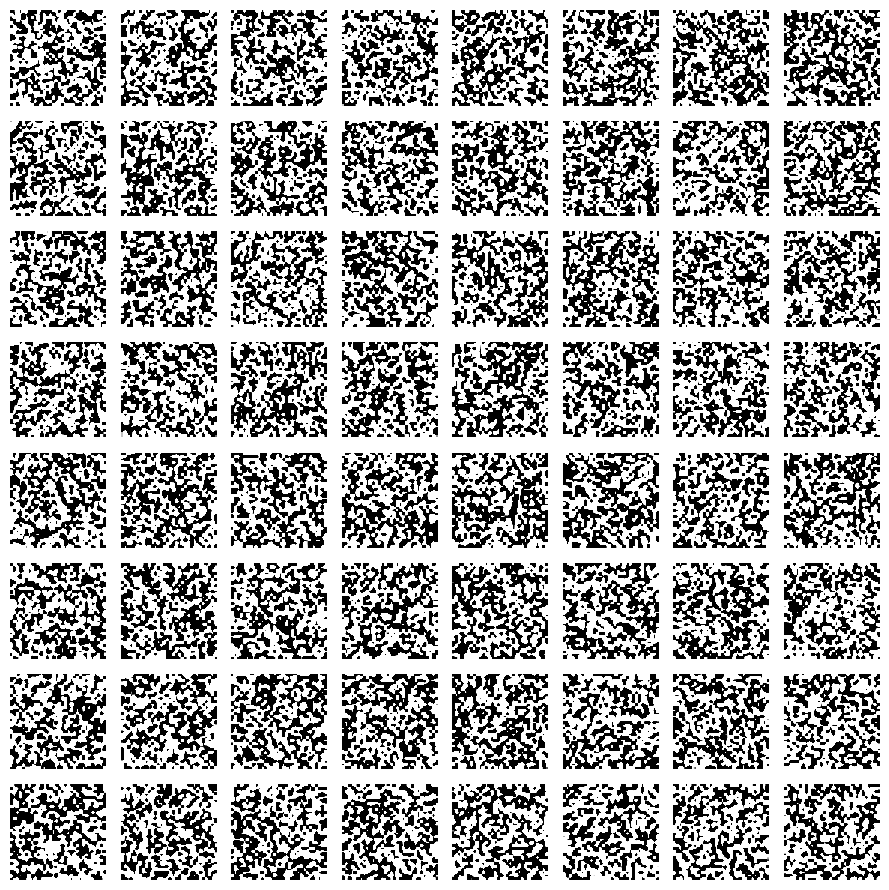

Epoch 1/427
  4/117 [>.............................] - ETA: 2s - loss: 504.4142   

117/117 [==============================] - 12s 42ms/step - loss: 837.2590 - val_loss: 479.8881
Epoch 2/427
117/117 [==============================] - 3s 22ms/step - loss: 482.0758 - val_loss: 466.3569
Epoch 3/427
117/117 [==============================] - 3s 22ms/step - loss: 447.2429 - val_loss: 429.3752
Epoch 4/427
117/117 [==============================] - 3s 22ms/step - loss: 404.9096 - val_loss: 409.9712
Epoch 5/427
117/117 [==============================] - 3s 22ms/step - loss: 391.1127 - val_loss: 418.3363
Epoch 6/427
117/117 [==============================] - 3s 22ms/step - loss: 373.1243 - val_loss: 354.5887
Epoch 7/427
117/117 [==============================] - 3s 23ms/step - loss: 346.5993 - val_loss: 310.6186
Epoch 8/427
117/117 [==============================] - 3s 22ms/step - loss: 322.3950 - val_loss: 284.0848
Epoch 9/427
117/117 [==============================] - 3s 22ms/step - loss: 274.3668 - val_loss: 258.7357
Epoch 10/427
117/117 [==============================] - 3

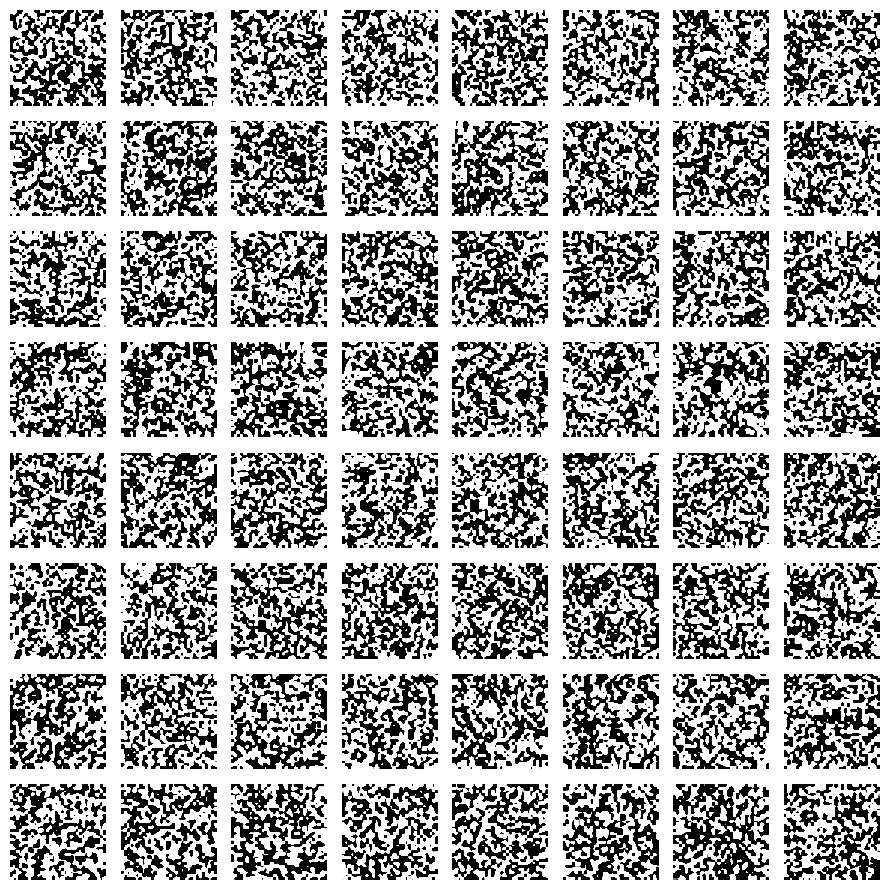

Epoch 21/427
117/117 [==============================] - 3s 22ms/step - loss: 152.2793 - val_loss: 107.5144
Epoch 22/427
117/117 [==============================] - 3s 22ms/step - loss: 138.8928 - val_loss: 129.1587
Epoch 23/427
117/117 [==============================] - 3s 22ms/step - loss: 135.1243 - val_loss: 130.4181
Epoch 24/427
117/117 [==============================] - 3s 22ms/step - loss: 121.2969 - val_loss: 120.9548
Epoch 25/427
117/117 [==============================] - 3s 22ms/step - loss: 117.5400 - val_loss: 94.5960
Epoch 26/427
117/117 [==============================] - 3s 22ms/step - loss: 116.4555 - val_loss: 133.6472
Epoch 27/427
117/117 [==============================] - 3s 22ms/step - loss: 119.0173 - val_loss: 119.2436
Epoch 28/427
117/117 [==============================] - 3s 22ms/step - loss: 108.4217 - val_loss: 95.2588
Epoch 29/427
117/117 [==============================] - 3s 22ms/step - loss: 112.8019 - val_loss: 103.7143
Epoch 30/427
117/117 [=================

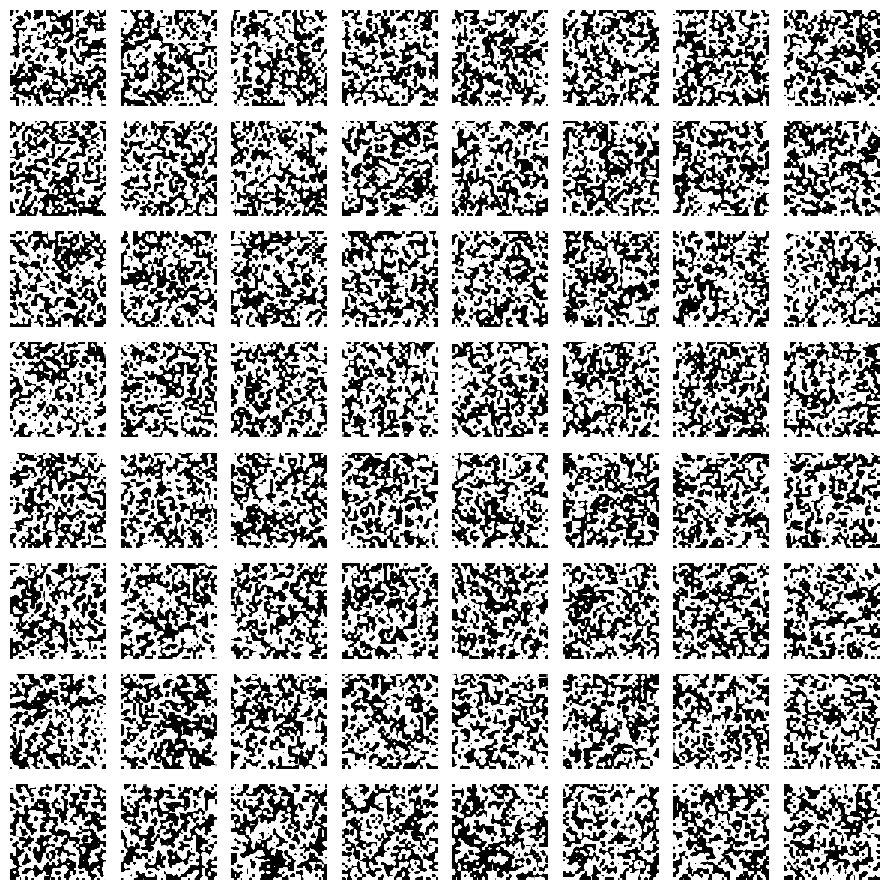

Epoch 41/427
117/117 [==============================] - 3s 22ms/step - loss: 84.6602 - val_loss: 75.1631
Epoch 42/427
117/117 [==============================] - 3s 22ms/step - loss: 86.0579 - val_loss: 79.6027
Epoch 43/427
117/117 [==============================] - 3s 22ms/step - loss: 84.7123 - val_loss: 79.4757
Epoch 44/427
117/117 [==============================] - 3s 22ms/step - loss: 74.2132 - val_loss: 77.2252
Epoch 45/427
117/117 [==============================] - 3s 22ms/step - loss: 77.7524 - val_loss: 95.1496
Epoch 46/427
117/117 [==============================] - 3s 22ms/step - loss: 80.7464 - val_loss: 120.6919
Epoch 47/427
117/117 [==============================] - 3s 22ms/step - loss: 80.8315 - val_loss: 62.4336
Epoch 48/427
117/117 [==============================] - 3s 22ms/step - loss: 70.9449 - val_loss: 64.4162
Epoch 49/427
117/117 [==============================] - 3s 22ms/step - loss: 75.9787 - val_loss: 75.2900
Epoch 50/427
117/117 [==============================] 

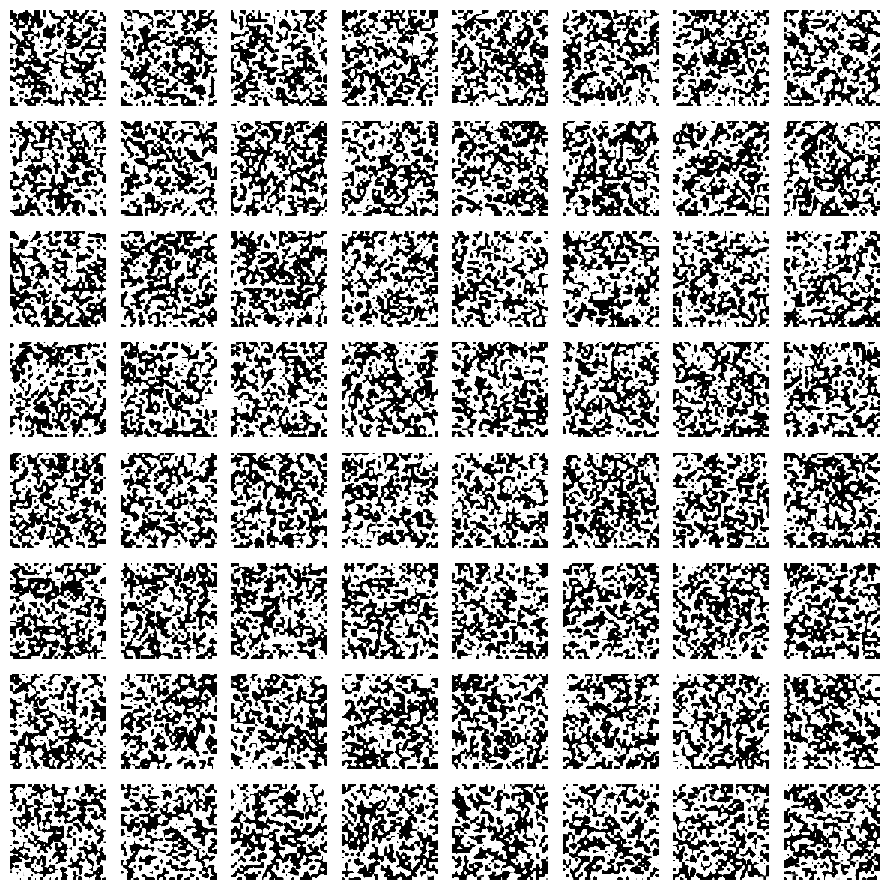

Epoch 61/427
117/117 [==============================] - 3s 22ms/step - loss: 62.1511 - val_loss: 66.9862
Epoch 62/427
117/117 [==============================] - 3s 22ms/step - loss: 59.5654 - val_loss: 83.3999
Epoch 63/427
117/117 [==============================] - 3s 22ms/step - loss: 85.3388 - val_loss: 70.6325
Epoch 64/427
117/117 [==============================] - 3s 22ms/step - loss: 66.1053 - val_loss: 57.6695
Epoch 65/427
117/117 [==============================] - 3s 22ms/step - loss: 72.6874 - val_loss: 79.0503
Epoch 66/427
117/117 [==============================] - 3s 22ms/step - loss: 64.4919 - val_loss: 69.0798
Epoch 67/427
117/117 [==============================] - 3s 22ms/step - loss: 67.2577 - val_loss: 60.7261
Epoch 68/427
117/117 [==============================] - 3s 22ms/step - loss: 72.6577 - val_loss: 60.1085
Epoch 69/427
117/117 [==============================] - 3s 22ms/step - loss: 63.0965 - val_loss: 70.1566
Epoch 70/427
117/117 [==============================] -

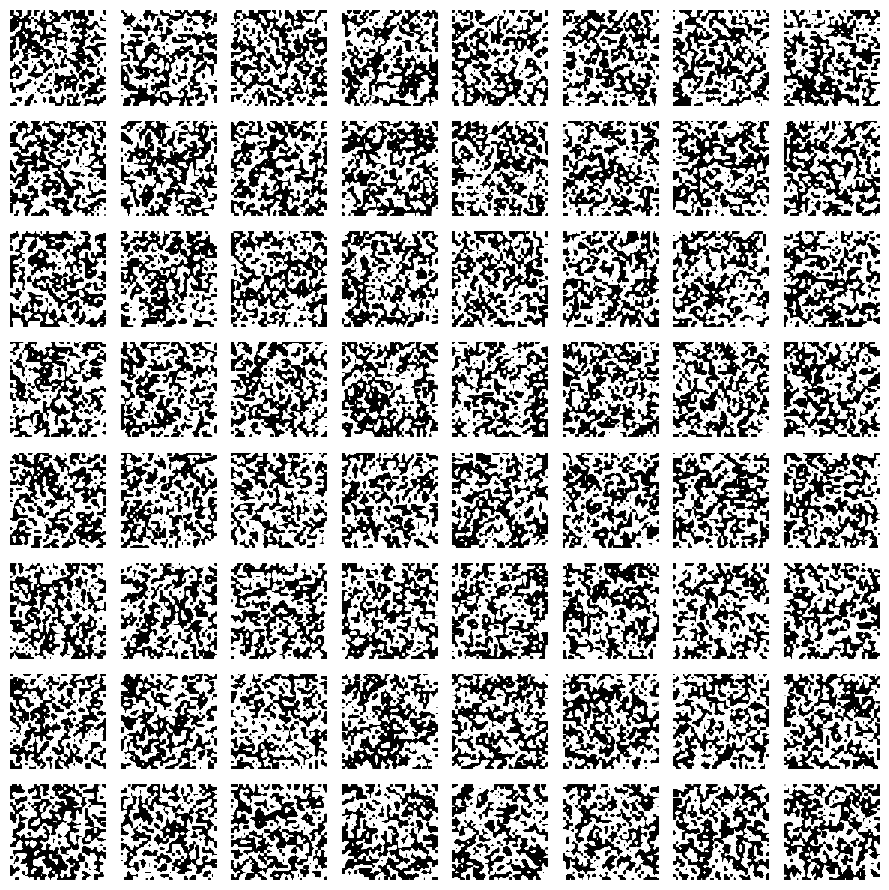

Epoch 81/427
117/117 [==============================] - 3s 22ms/step - loss: 62.7087 - val_loss: 44.3967
Epoch 82/427
117/117 [==============================] - 3s 22ms/step - loss: 64.2548 - val_loss: 61.4803
Epoch 83/427
117/117 [==============================] - 3s 22ms/step - loss: 61.5732 - val_loss: 63.1650
Epoch 84/427
117/117 [==============================] - 3s 22ms/step - loss: 59.6344 - val_loss: 56.5265
Epoch 85/427
117/117 [==============================] - 3s 22ms/step - loss: 60.1338 - val_loss: 56.1664
Epoch 86/427
117/117 [==============================] - 3s 22ms/step - loss: 61.1878 - val_loss: 69.2438
Epoch 87/427
117/117 [==============================] - 3s 22ms/step - loss: 60.8217 - val_loss: 70.7564
Epoch 88/427
117/117 [==============================] - 3s 22ms/step - loss: 61.8882 - val_loss: 68.6199
Epoch 89/427
117/117 [==============================] - 3s 22ms/step - loss: 67.7918 - val_loss: 55.0698
Epoch 90/427
117/117 [==============================] -

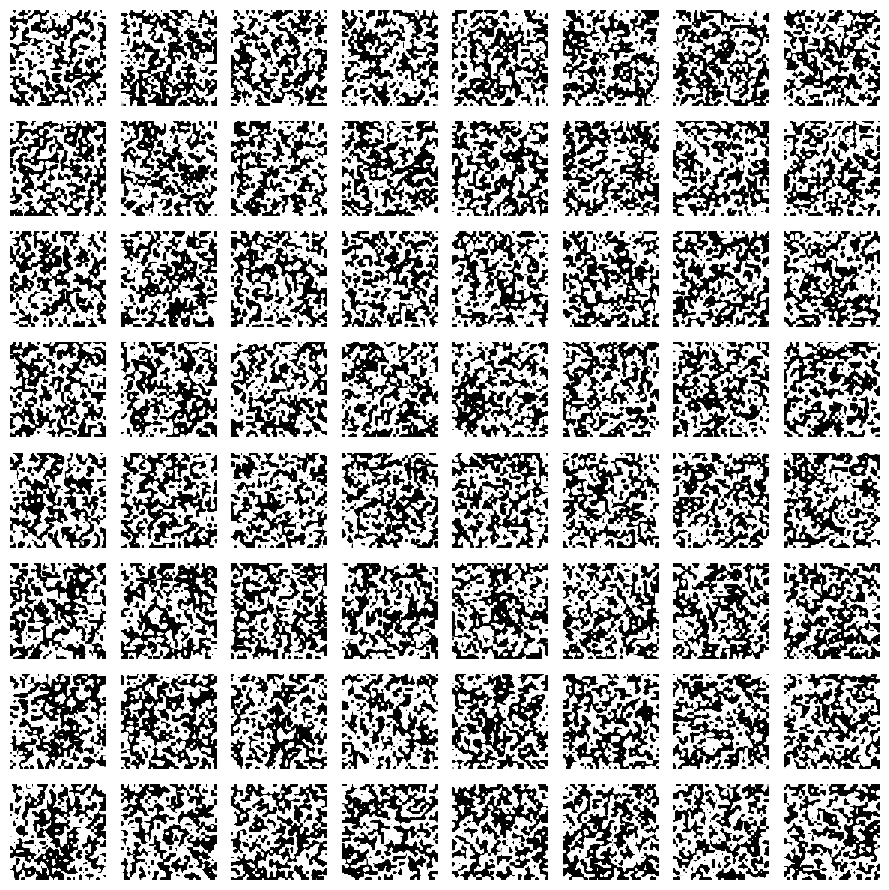

Epoch 101/427
117/117 [==============================] - 3s 22ms/step - loss: 56.7978 - val_loss: 44.9607
Epoch 102/427
117/117 [==============================] - 3s 22ms/step - loss: 53.8578 - val_loss: 59.3896
Epoch 103/427
117/117 [==============================] - 3s 22ms/step - loss: 67.5822 - val_loss: 76.5961
Epoch 104/427
117/117 [==============================] - 3s 22ms/step - loss: 57.0187 - val_loss: 57.9266
Epoch 105/427
117/117 [==============================] - 3s 22ms/step - loss: 58.7021 - val_loss: 50.0541
Epoch 106/427
117/117 [==============================] - 3s 22ms/step - loss: 61.6103 - val_loss: 55.3862
Epoch 107/427
117/117 [==============================] - 3s 22ms/step - loss: 53.5427 - val_loss: 49.7501
Epoch 108/427
117/117 [==============================] - 3s 22ms/step - loss: 50.0359 - val_loss: 66.5944
Epoch 109/427
117/117 [==============================] - 3s 22ms/step - loss: 65.1849 - val_loss: 57.7896
Epoch 110/427
117/117 [=======================

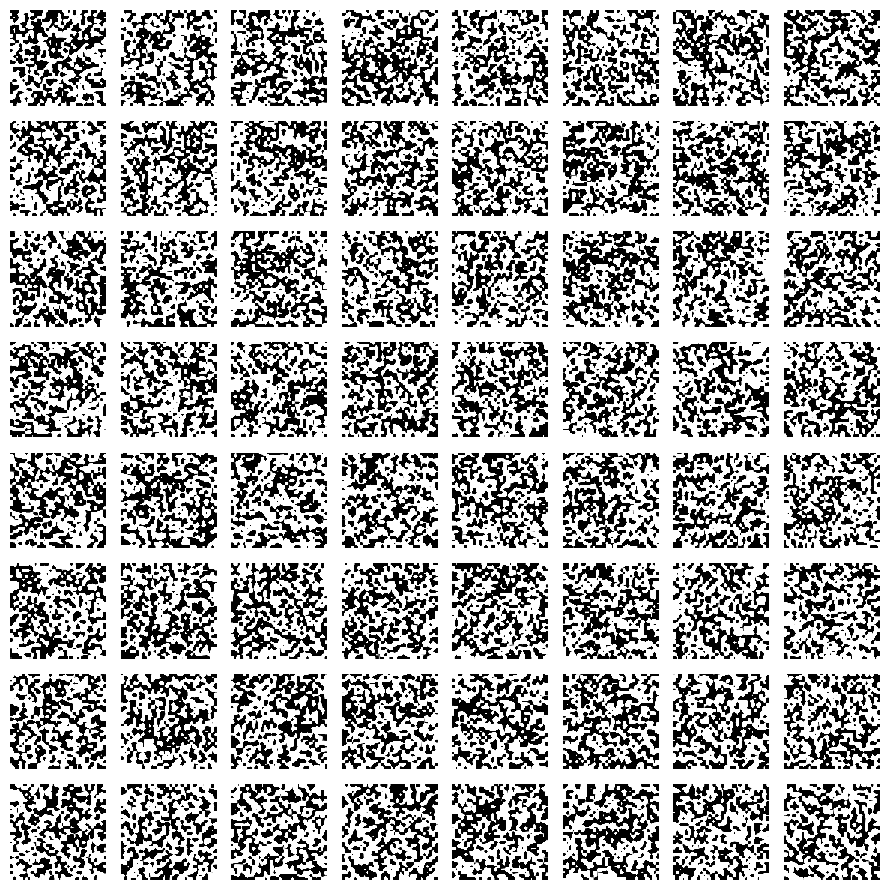

Epoch 121/427
117/117 [==============================] - 3s 22ms/step - loss: 51.3731 - val_loss: 53.0086
Epoch 122/427
117/117 [==============================] - 3s 22ms/step - loss: 55.0402 - val_loss: 52.4979
Epoch 123/427
117/117 [==============================] - 3s 22ms/step - loss: 47.5570 - val_loss: 50.9177
Epoch 124/427
117/117 [==============================] - 3s 22ms/step - loss: 52.1255 - val_loss: 70.3284
Epoch 125/427
117/117 [==============================] - 3s 22ms/step - loss: 73.9343 - val_loss: 51.0267
Epoch 126/427
117/117 [==============================] - 3s 22ms/step - loss: 56.1314 - val_loss: 55.3947
Epoch 127/427
117/117 [==============================] - 3s 22ms/step - loss: 49.6904 - val_loss: 42.6496
Epoch 128/427
117/117 [==============================] - 3s 22ms/step - loss: 50.3731 - val_loss: 52.3084
Epoch 129/427
117/117 [==============================] - 3s 22ms/step - loss: 56.0844 - val_loss: 61.4938
Epoch 130/427
117/117 [=======================

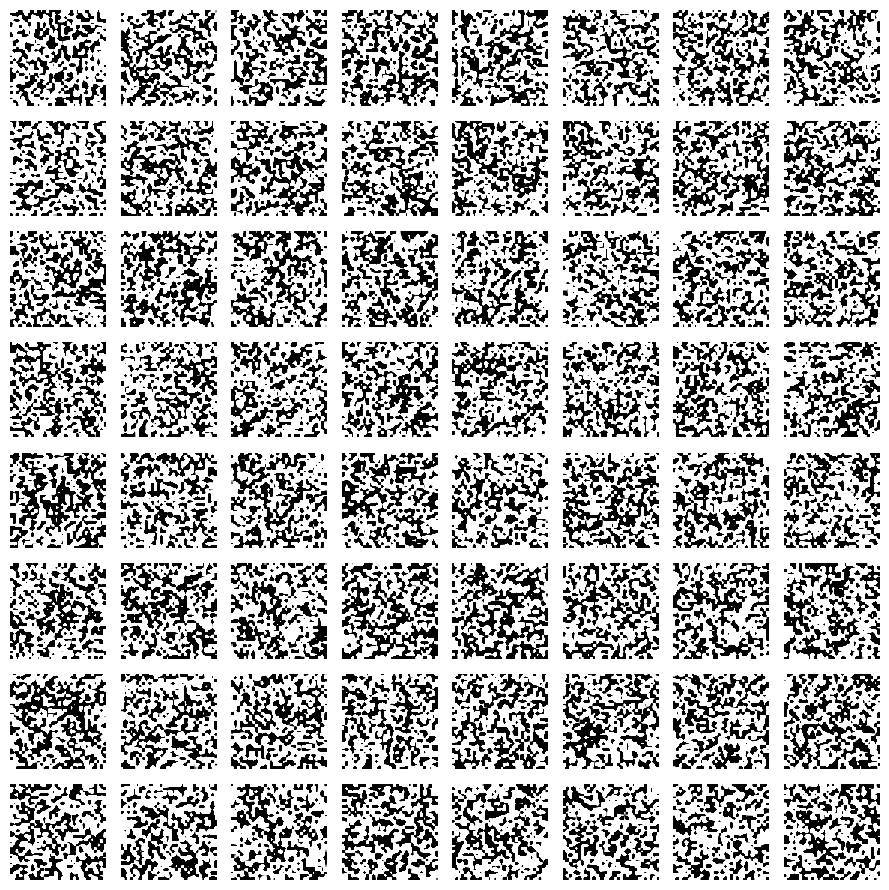

Epoch 141/427
117/117 [==============================] - 3s 22ms/step - loss: 49.4249 - val_loss: 39.2860
Epoch 142/427
117/117 [==============================] - 3s 22ms/step - loss: 50.7667 - val_loss: 55.2563
Epoch 143/427
117/117 [==============================] - 3s 22ms/step - loss: 49.6369 - val_loss: 38.7476
Epoch 144/427
117/117 [==============================] - 3s 22ms/step - loss: 41.9363 - val_loss: 54.0163
Epoch 145/427
117/117 [==============================] - 3s 22ms/step - loss: 45.9229 - val_loss: 67.9714
Epoch 146/427
117/117 [==============================] - 3s 22ms/step - loss: 47.6550 - val_loss: 46.9478
Epoch 147/427
117/117 [==============================] - 3s 22ms/step - loss: 50.9297 - val_loss: 51.5905
Epoch 148/427
117/117 [==============================] - 3s 22ms/step - loss: 50.1085 - val_loss: 57.2339
Epoch 149/427
117/117 [==============================] - 3s 22ms/step - loss: 43.8077 - val_loss: 42.0297
Epoch 150/427
117/117 [=======================

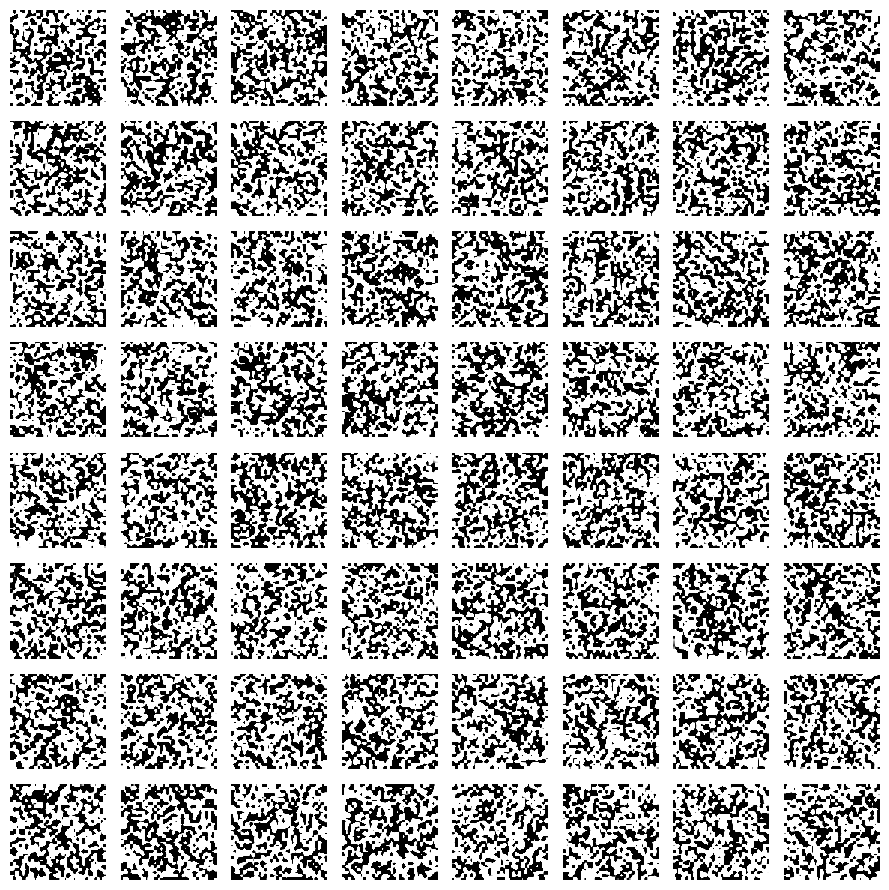

Epoch 161/427
117/117 [==============================] - 3s 22ms/step - loss: 48.3720 - val_loss: 35.5903
Epoch 162/427
117/117 [==============================] - 3s 22ms/step - loss: 47.8373 - val_loss: 36.8450
Epoch 163/427
117/117 [==============================] - 3s 22ms/step - loss: 50.1268 - val_loss: 57.4039
Epoch 164/427
117/117 [==============================] - 3s 22ms/step - loss: 45.2867 - val_loss: 36.7266
Epoch 165/427
117/117 [==============================] - 3s 22ms/step - loss: 47.7426 - val_loss: 41.8180
Epoch 166/427
117/117 [==============================] - 3s 22ms/step - loss: 45.5132 - val_loss: 44.3800
Epoch 167/427
117/117 [==============================] - 3s 22ms/step - loss: 48.6923 - val_loss: 38.0392
Epoch 168/427
117/117 [==============================] - 3s 22ms/step - loss: 48.6191 - val_loss: 40.0591
Epoch 169/427
117/117 [==============================] - 3s 22ms/step - loss: 44.4799 - val_loss: 46.2354
Epoch 170/427
117/117 [=======================

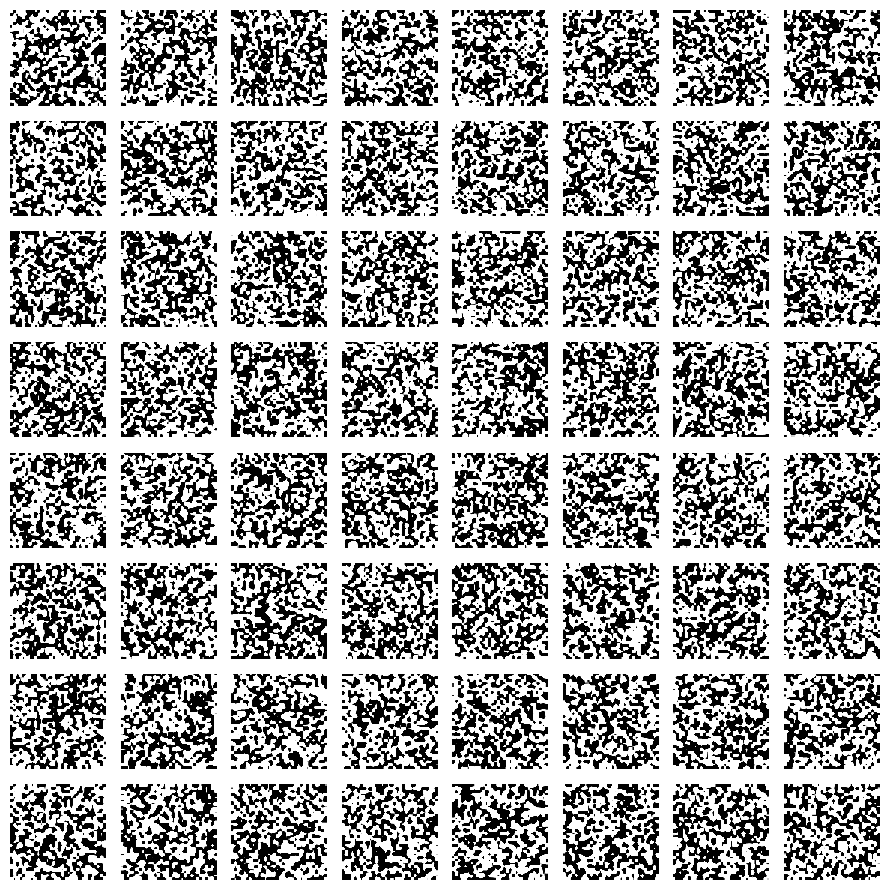

Epoch 181/427
117/117 [==============================] - 3s 22ms/step - loss: 45.9321 - val_loss: 40.7679
Epoch 182/427
117/117 [==============================] - 3s 22ms/step - loss: 49.6583 - val_loss: 42.6310
Epoch 183/427
117/117 [==============================] - 3s 22ms/step - loss: 44.2129 - val_loss: 43.7542
Epoch 184/427
117/117 [==============================] - 3s 22ms/step - loss: 41.1269 - val_loss: 45.2191
Epoch 185/427
117/117 [==============================] - 3s 22ms/step - loss: 44.0569 - val_loss: 45.4784
Epoch 186/427
117/117 [==============================] - 3s 22ms/step - loss: 44.1460 - val_loss: 41.4838
Epoch 187/427
117/117 [==============================] - 3s 22ms/step - loss: 42.3736 - val_loss: 44.5934
Epoch 188/427
117/117 [==============================] - 3s 22ms/step - loss: 49.8624 - val_loss: 39.8037
Epoch 189/427
117/117 [==============================] - 3s 22ms/step - loss: 42.8667 - val_loss: 41.1112
Epoch 190/427
117/117 [=======================

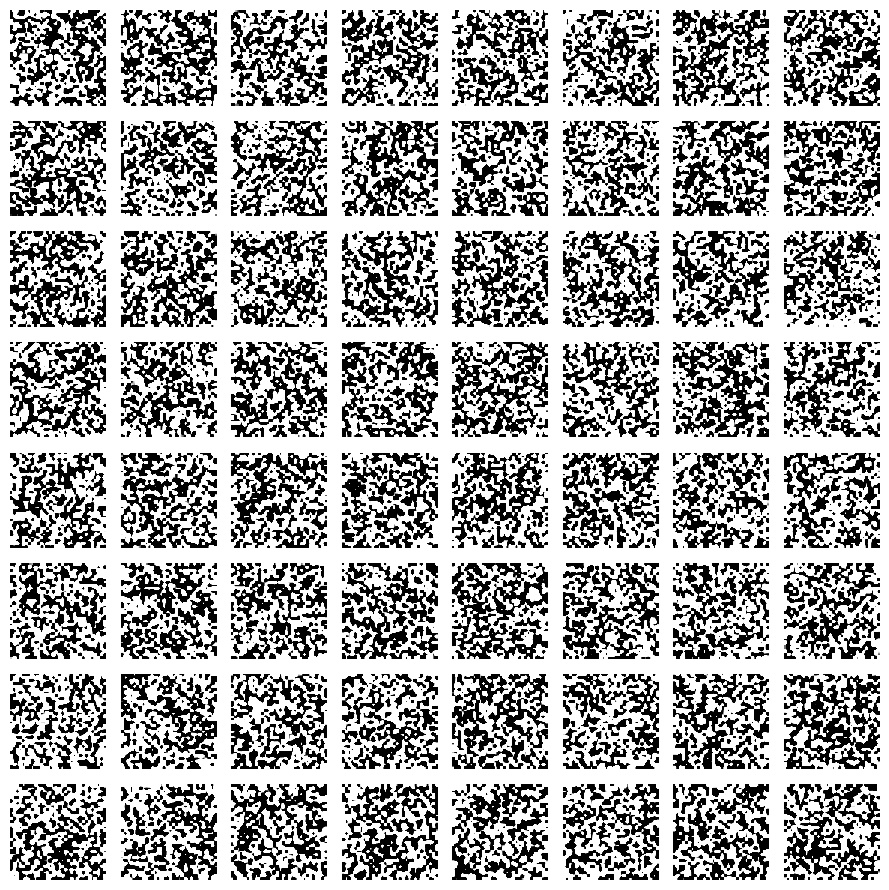

Epoch 201/427
117/117 [==============================] - 3s 22ms/step - loss: 41.7328 - val_loss: 35.6476
Epoch 202/427
117/117 [==============================] - 3s 22ms/step - loss: 43.4242 - val_loss: 47.1757
Epoch 203/427
117/117 [==============================] - 3s 22ms/step - loss: 49.2855 - val_loss: 42.9004
Epoch 204/427
117/117 [==============================] - 3s 22ms/step - loss: 41.1225 - val_loss: 52.9673
Epoch 205/427
117/117 [==============================] - 3s 22ms/step - loss: 43.7103 - val_loss: 43.9807
Epoch 206/427
117/117 [==============================] - 3s 22ms/step - loss: 43.0053 - val_loss: 39.4749
Epoch 207/427
117/117 [==============================] - 3s 22ms/step - loss: 41.5804 - val_loss: 36.0962
Epoch 208/427
117/117 [==============================] - 3s 22ms/step - loss: 41.9446 - val_loss: 40.6354
Epoch 209/427
117/117 [==============================] - 3s 22ms/step - loss: 41.5357 - val_loss: 52.6667
Epoch 210/427
117/117 [=======================

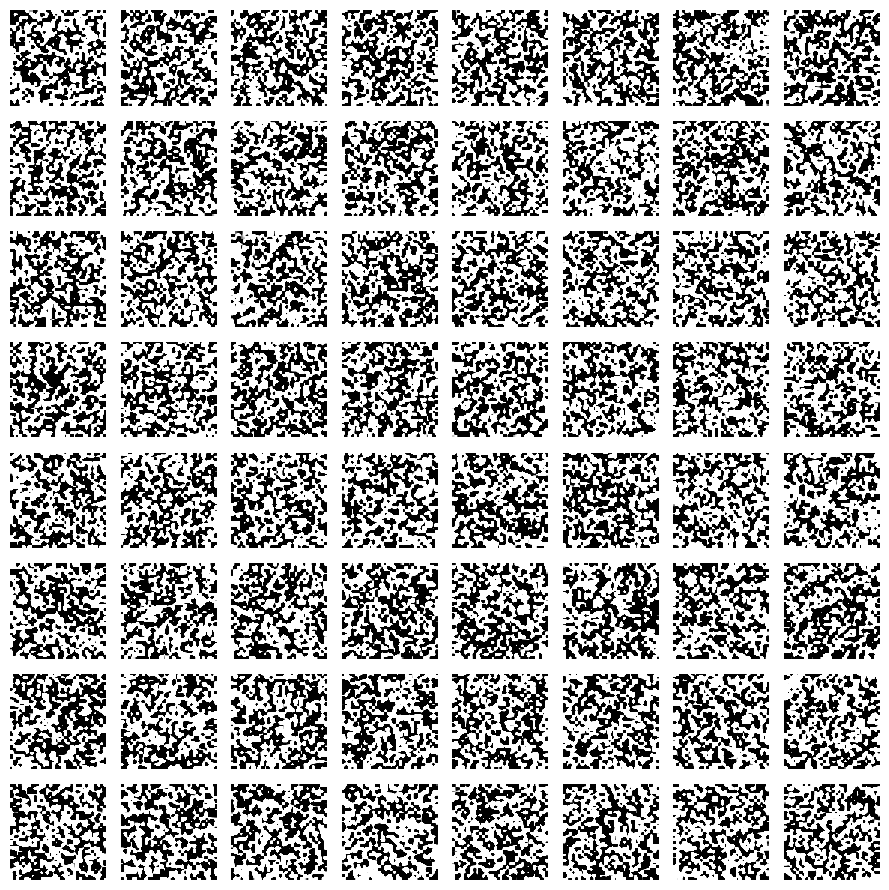

Epoch 221/427
117/117 [==============================] - 3s 22ms/step - loss: 44.3496 - val_loss: 64.3388
Epoch 222/427
117/117 [==============================] - 3s 22ms/step - loss: 43.8208 - val_loss: 45.9591
Epoch 223/427
117/117 [==============================] - 3s 22ms/step - loss: 44.1058 - val_loss: 42.5339
Epoch 224/427
117/117 [==============================] - 3s 22ms/step - loss: 39.5936 - val_loss: 40.9186
Epoch 225/427
117/117 [==============================] - 3s 22ms/step - loss: 38.5416 - val_loss: 44.3923
Epoch 226/427
117/117 [==============================] - 3s 22ms/step - loss: 40.1911 - val_loss: 41.4695
Epoch 227/427
117/117 [==============================] - 3s 22ms/step - loss: 45.4846 - val_loss: 42.9227
Epoch 228/427
117/117 [==============================] - 3s 22ms/step - loss: 42.7470 - val_loss: 38.7896
Epoch 229/427
117/117 [==============================] - 3s 22ms/step - loss: 43.4158 - val_loss: 40.0052
Epoch 230/427
117/117 [=======================

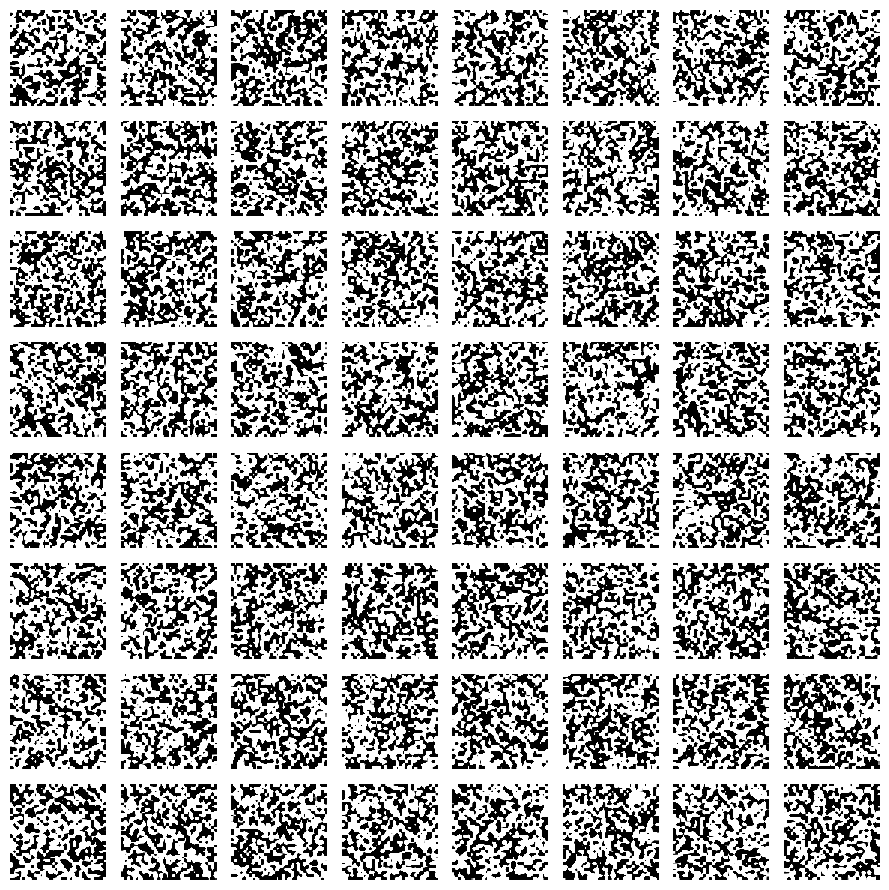

Epoch 241/427
117/117 [==============================] - 3s 22ms/step - loss: 40.8831 - val_loss: 37.0423
Epoch 242/427
117/117 [==============================] - 3s 22ms/step - loss: 41.0494 - val_loss: 31.9319
Epoch 243/427
117/117 [==============================] - 3s 22ms/step - loss: 40.1536 - val_loss: 32.6773
Epoch 244/427
117/117 [==============================] - 3s 22ms/step - loss: 38.3234 - val_loss: 40.8190
Epoch 245/427
117/117 [==============================] - 3s 22ms/step - loss: 42.7800 - val_loss: 36.0120
Epoch 246/427
117/117 [==============================] - 3s 22ms/step - loss: 41.9430 - val_loss: 32.9733
Epoch 247/427
117/117 [==============================] - 3s 22ms/step - loss: 40.9578 - val_loss: 43.5492
Epoch 248/427
117/117 [==============================] - 3s 22ms/step - loss: 40.2002 - val_loss: 37.5283
Epoch 249/427
117/117 [==============================] - 3s 22ms/step - loss: 37.3400 - val_loss: 33.5217
Epoch 250/427
117/117 [=======================

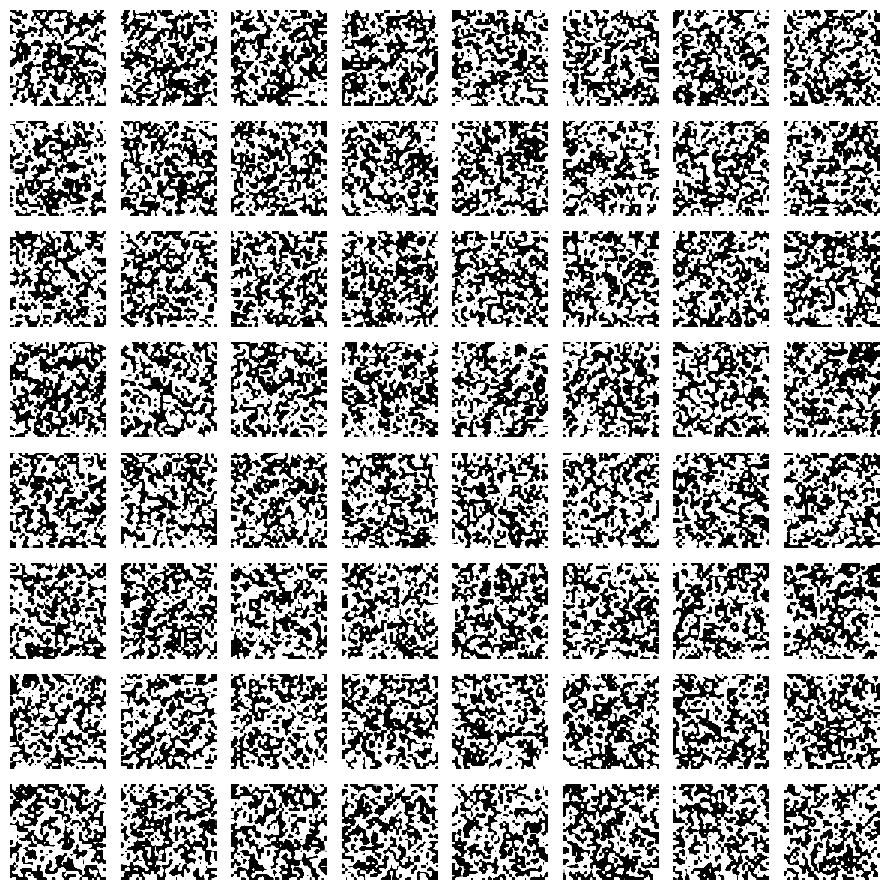

Epoch 261/427
117/117 [==============================] - 3s 22ms/step - loss: 34.6023 - val_loss: 33.7326
Epoch 262/427
117/117 [==============================] - 3s 22ms/step - loss: 38.5986 - val_loss: 45.4416
Epoch 263/427
117/117 [==============================] - 3s 22ms/step - loss: 38.1915 - val_loss: 29.9396
Epoch 264/427
117/117 [==============================] - 3s 22ms/step - loss: 45.8146 - val_loss: 44.6247
Epoch 265/427
117/117 [==============================] - 3s 22ms/step - loss: 39.4435 - val_loss: 45.4575
Epoch 266/427
117/117 [==============================] - 3s 23ms/step - loss: 35.6869 - val_loss: 43.2576
Epoch 267/427
117/117 [==============================] - 3s 22ms/step - loss: 35.2425 - val_loss: 33.4809
Epoch 268/427
117/117 [==============================] - 3s 22ms/step - loss: 37.4251 - val_loss: 43.4922
Epoch 269/427
117/117 [==============================] - 3s 22ms/step - loss: 35.2780 - val_loss: 36.3655
Epoch 270/427
117/117 [=======================

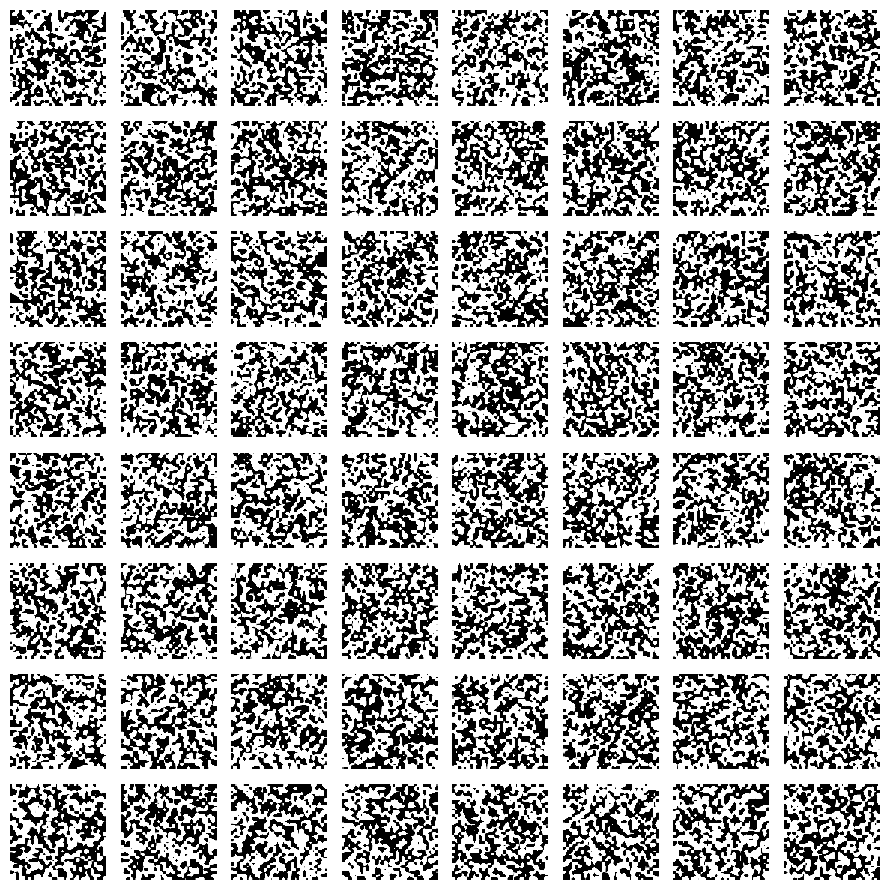

Epoch 281/427
117/117 [==============================] - 3s 22ms/step - loss: 37.8069 - val_loss: 42.7406
Epoch 282/427
117/117 [==============================] - 3s 22ms/step - loss: 38.7816 - val_loss: 29.4889
Epoch 283/427
117/117 [==============================] - 3s 22ms/step - loss: 37.8057 - val_loss: 51.0408
Epoch 284/427
117/117 [==============================] - 3s 22ms/step - loss: 38.1430 - val_loss: 37.8594
Epoch 285/427
117/117 [==============================] - 3s 22ms/step - loss: 36.7991 - val_loss: 33.2657
Epoch 286/427
117/117 [==============================] - 3s 22ms/step - loss: 41.1864 - val_loss: 37.7655
Epoch 287/427
117/117 [==============================] - 3s 22ms/step - loss: 35.4087 - val_loss: 31.4308
Epoch 288/427
117/117 [==============================] - 3s 22ms/step - loss: 36.7495 - val_loss: 45.3680
Epoch 289/427
117/117 [==============================] - 3s 22ms/step - loss: 40.7049 - val_loss: 45.5643
Epoch 290/427
117/117 [=======================

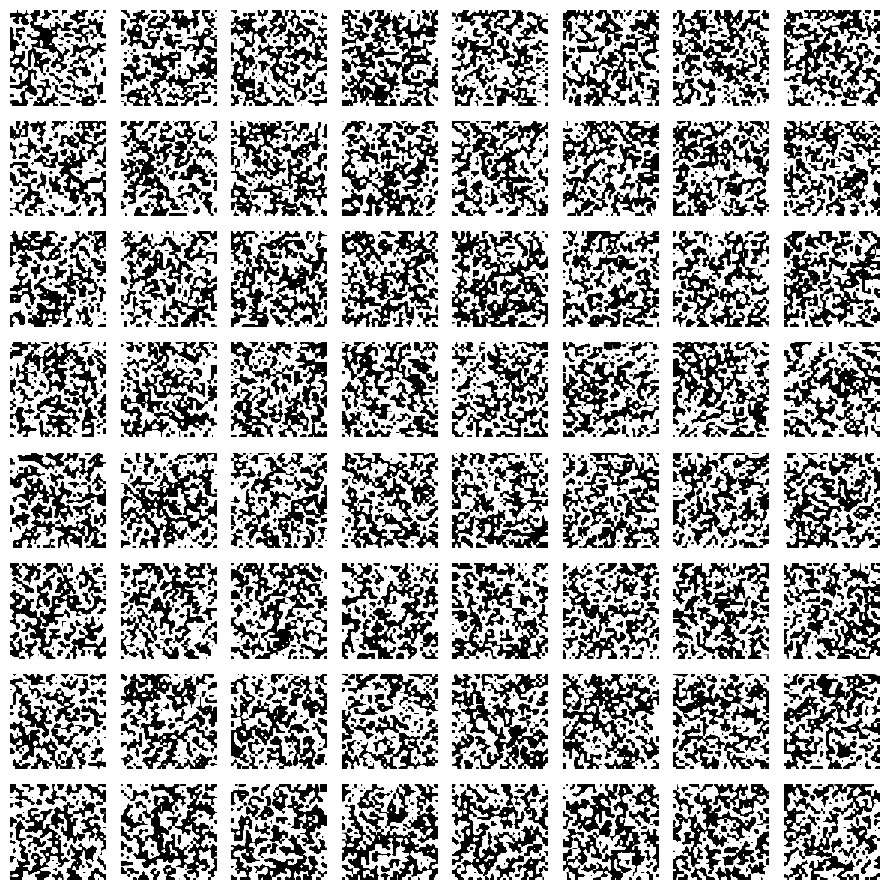

Epoch 301/427
117/117 [==============================] - 3s 22ms/step - loss: 31.3359 - val_loss: 34.4369
Epoch 302/427
117/117 [==============================] - 3s 22ms/step - loss: 36.9369 - val_loss: 49.3093
Epoch 303/427
117/117 [==============================] - 3s 22ms/step - loss: 33.7778 - val_loss: 44.2577
Epoch 304/427
117/117 [==============================] - 3s 22ms/step - loss: 43.9694 - val_loss: 33.9330
Epoch 305/427
117/117 [==============================] - 3s 22ms/step - loss: 29.7385 - val_loss: 43.0267
Epoch 306/427
117/117 [==============================] - 3s 22ms/step - loss: 39.2404 - val_loss: 40.0680
Epoch 307/427
117/117 [==============================] - 3s 22ms/step - loss: 35.2155 - val_loss: 35.2270
Epoch 308/427
117/117 [==============================] - 3s 22ms/step - loss: 37.7946 - val_loss: 37.7460
Epoch 309/427
117/117 [==============================] - 3s 22ms/step - loss: 37.0845 - val_loss: 29.3229
Epoch 310/427
117/117 [=======================

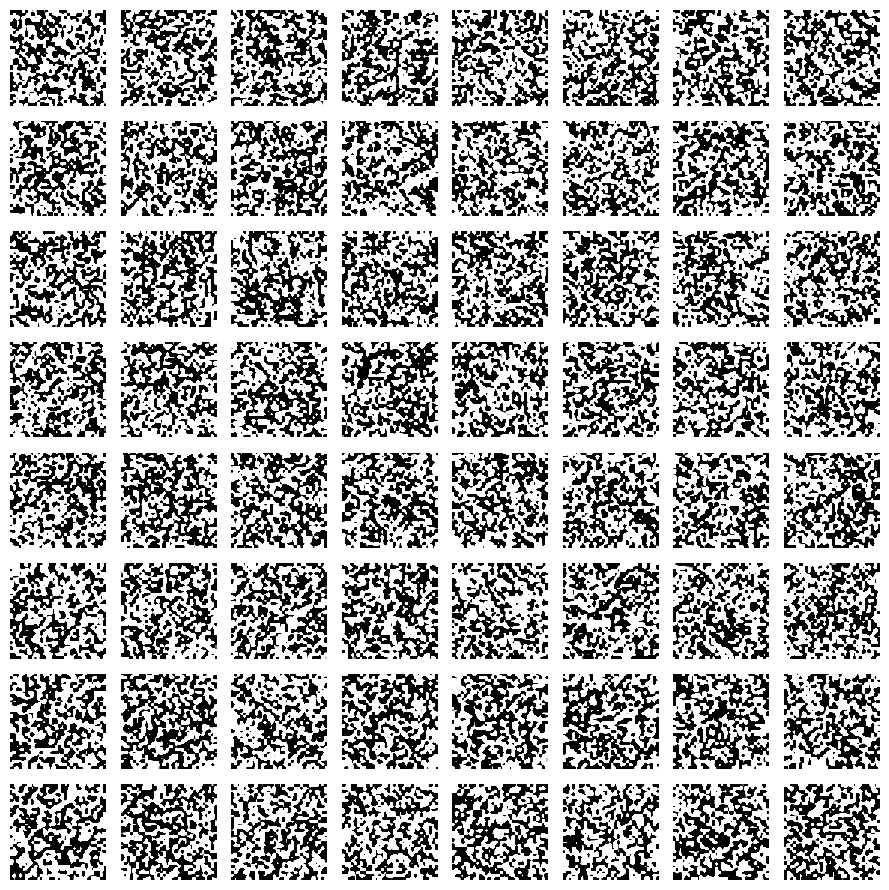

Epoch 321/427
117/117 [==============================] - 3s 22ms/step - loss: 35.5827 - val_loss: 43.8732
Epoch 322/427
117/117 [==============================] - 3s 22ms/step - loss: 38.3584 - val_loss: 32.0422
Epoch 323/427
117/117 [==============================] - 3s 22ms/step - loss: 39.1714 - val_loss: 37.7699
Epoch 324/427
117/117 [==============================] - 3s 22ms/step - loss: 37.4246 - val_loss: 33.2766
Epoch 325/427
117/117 [==============================] - 3s 22ms/step - loss: 34.5358 - val_loss: 39.8743
Epoch 326/427
117/117 [==============================] - 3s 22ms/step - loss: 37.2293 - val_loss: 35.4821
Epoch 327/427
117/117 [==============================] - 3s 22ms/step - loss: 34.2334 - val_loss: 35.8215
Epoch 328/427
117/117 [==============================] - 3s 22ms/step - loss: 37.8790 - val_loss: 39.7881
Epoch 329/427
117/117 [==============================] - 3s 22ms/step - loss: 39.5837 - val_loss: 37.9187
Epoch 330/427
117/117 [=======================

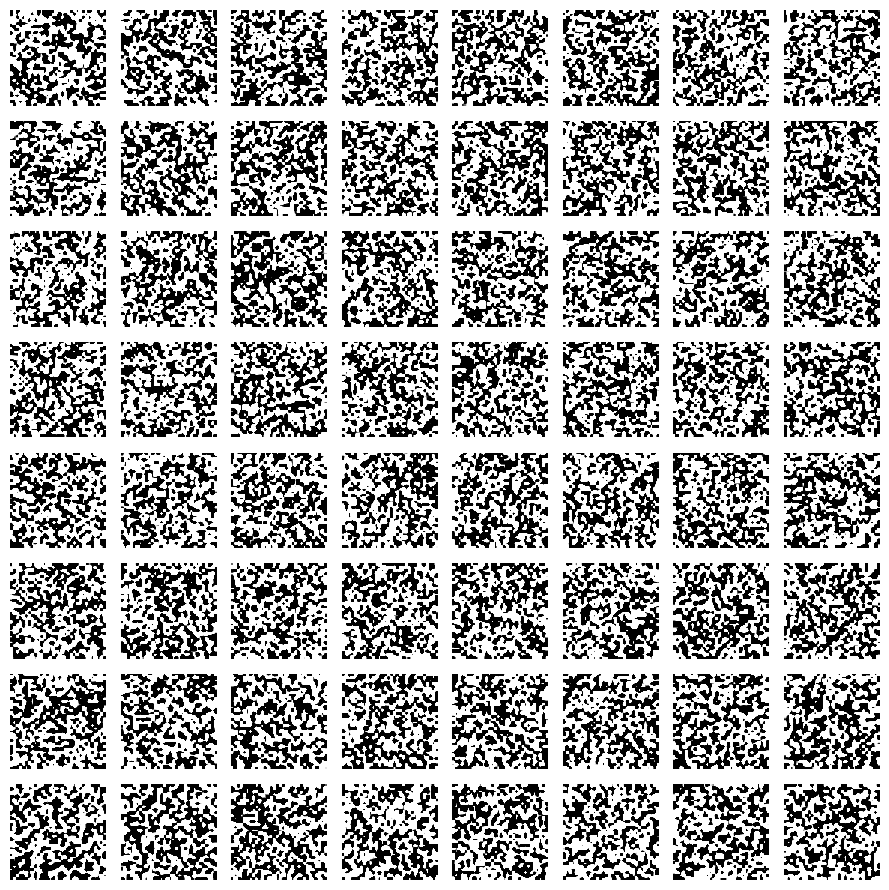

Epoch 341/427
117/117 [==============================] - 3s 22ms/step - loss: 30.9735 - val_loss: 31.2322
Epoch 342/427
117/117 [==============================] - 3s 22ms/step - loss: 32.4231 - val_loss: 38.0064
Epoch 343/427
117/117 [==============================] - 3s 22ms/step - loss: 35.1814 - val_loss: 45.7918
Epoch 344/427
117/117 [==============================] - 3s 22ms/step - loss: 33.3133 - val_loss: 33.8667
Epoch 345/427
117/117 [==============================] - 3s 22ms/step - loss: 37.4638 - val_loss: 47.5899
Epoch 346/427
117/117 [==============================] - 3s 22ms/step - loss: 37.3890 - val_loss: 34.1660
Epoch 347/427
117/117 [==============================] - 3s 22ms/step - loss: 39.5019 - val_loss: 42.7893
Epoch 348/427
117/117 [==============================] - 3s 22ms/step - loss: 39.0470 - val_loss: 30.7234
Epoch 349/427
117/117 [==============================] - 3s 22ms/step - loss: 39.6230 - val_loss: 38.2830
Epoch 350/427
117/117 [=======================

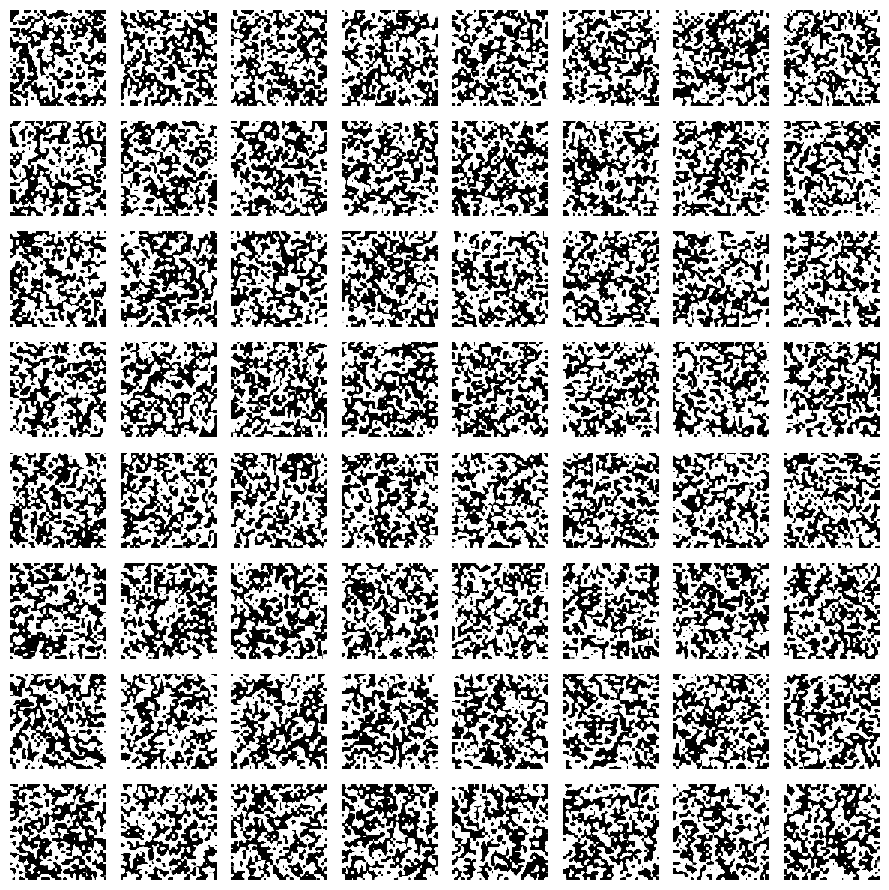

Epoch 361/427
117/117 [==============================] - 3s 22ms/step - loss: 37.7565 - val_loss: 35.4795
Epoch 362/427
117/117 [==============================] - 3s 22ms/step - loss: 40.7350 - val_loss: 33.5811
Epoch 363/427
117/117 [==============================] - 3s 22ms/step - loss: 35.5501 - val_loss: 35.4963
Epoch 364/427
117/117 [==============================] - 3s 22ms/step - loss: 32.9991 - val_loss: 46.5897
Epoch 365/427
117/117 [==============================] - 3s 22ms/step - loss: 34.1272 - val_loss: 46.5374
Epoch 366/427
117/117 [==============================] - 3s 22ms/step - loss: 36.8419 - val_loss: 32.8622
Epoch 367/427
117/117 [==============================] - 3s 22ms/step - loss: 34.7239 - val_loss: 32.1497
Epoch 368/427
117/117 [==============================] - 3s 22ms/step - loss: 35.9392 - val_loss: 29.6668
Epoch 369/427
117/117 [==============================] - 3s 22ms/step - loss: 35.8163 - val_loss: 36.7700
Epoch 370/427
117/117 [=======================

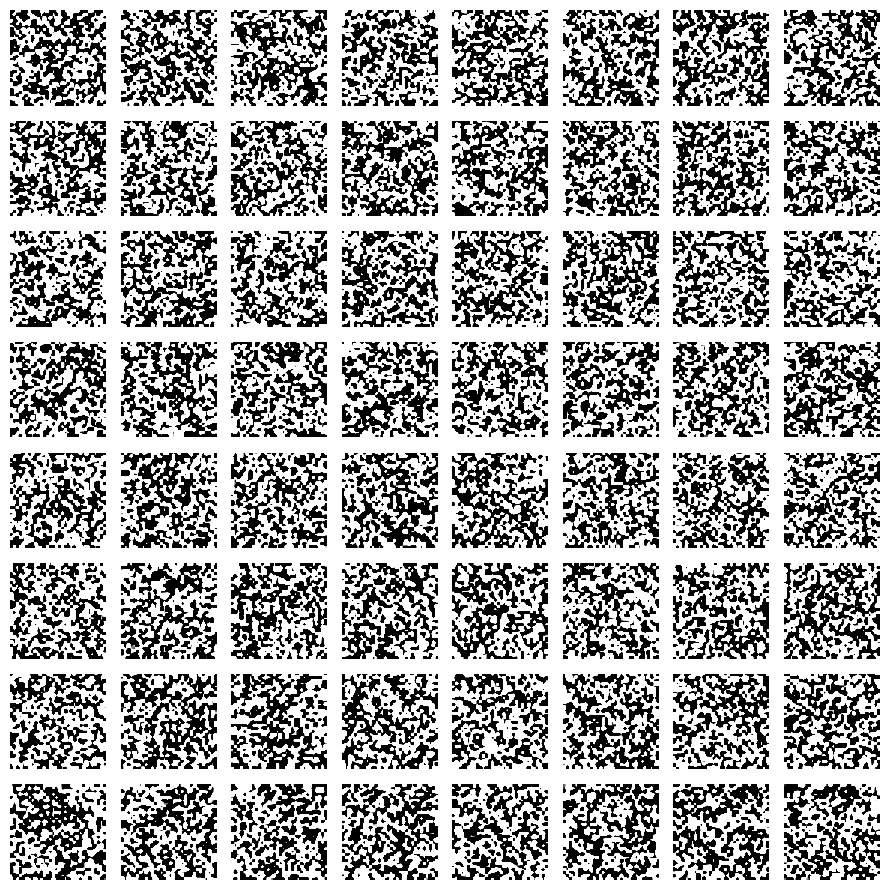

Epoch 381/427
117/117 [==============================] - 3s 22ms/step - loss: 36.2243 - val_loss: 21.3302
Epoch 382/427
117/117 [==============================] - 3s 22ms/step - loss: 35.4965 - val_loss: 27.0130
Epoch 383/427
117/117 [==============================] - 3s 22ms/step - loss: 38.3037 - val_loss: 38.3398
Epoch 384/427
117/117 [==============================] - 3s 22ms/step - loss: 37.3072 - val_loss: 36.7627
Epoch 385/427
117/117 [==============================] - 3s 22ms/step - loss: 29.7330 - val_loss: 38.5291
Epoch 386/427
117/117 [==============================] - 3s 22ms/step - loss: 31.4230 - val_loss: 33.9152
Epoch 387/427
117/117 [==============================] - 3s 22ms/step - loss: 34.5869 - val_loss: 41.3531
Epoch 388/427
117/117 [==============================] - 3s 22ms/step - loss: 34.1326 - val_loss: 48.0405
Epoch 389/427
117/117 [==============================] - 3s 22ms/step - loss: 38.8357 - val_loss: 35.1104
Epoch 390/427
117/117 [=======================

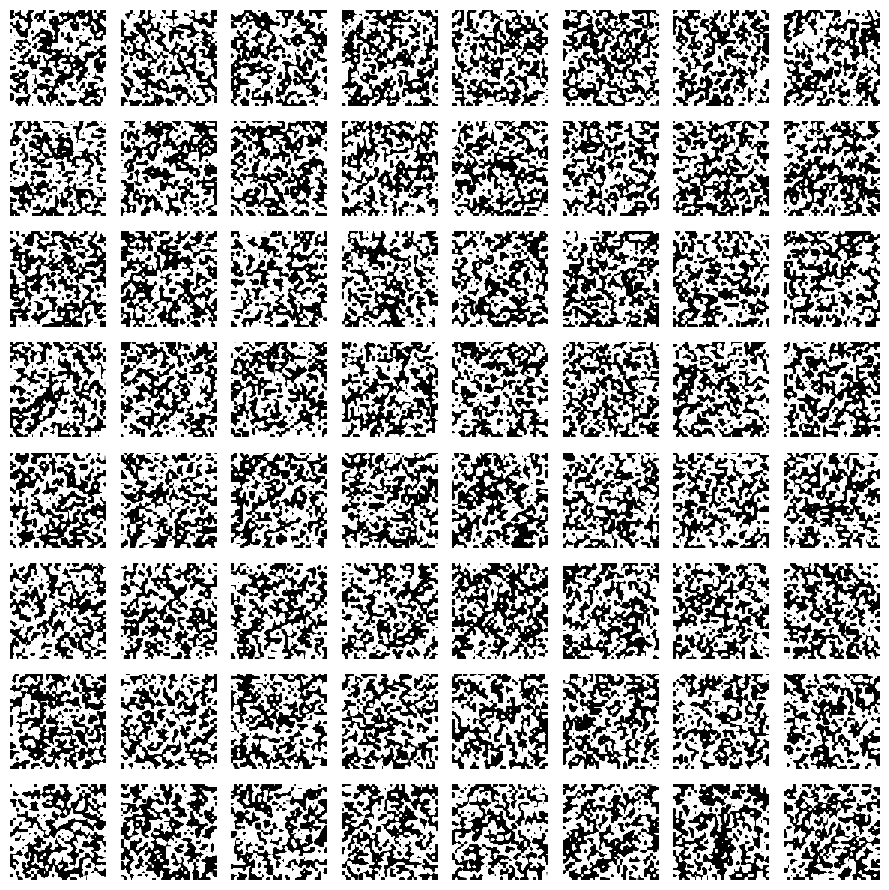

Epoch 401/427
117/117 [==============================] - 3s 22ms/step - loss: 30.8669 - val_loss: 36.5366
Epoch 402/427
117/117 [==============================] - 3s 22ms/step - loss: 32.9981 - val_loss: 33.3639
Epoch 403/427
117/117 [==============================] - 3s 22ms/step - loss: 38.6105 - val_loss: 31.1830
Epoch 404/427
117/117 [==============================] - 3s 22ms/step - loss: 32.4082 - val_loss: 36.4052
Epoch 405/427
117/117 [==============================] - 3s 22ms/step - loss: 33.4524 - val_loss: 37.1096
Epoch 406/427
117/117 [==============================] - 3s 22ms/step - loss: 39.3822 - val_loss: 36.5421
Epoch 407/427
117/117 [==============================] - 3s 22ms/step - loss: 33.9913 - val_loss: 25.5911
Epoch 408/427
117/117 [==============================] - 3s 22ms/step - loss: 31.6334 - val_loss: 37.8810
Epoch 409/427
117/117 [==============================] - 3s 22ms/step - loss: 36.5941 - val_loss: 28.5484
Epoch 410/427
117/117 [=======================

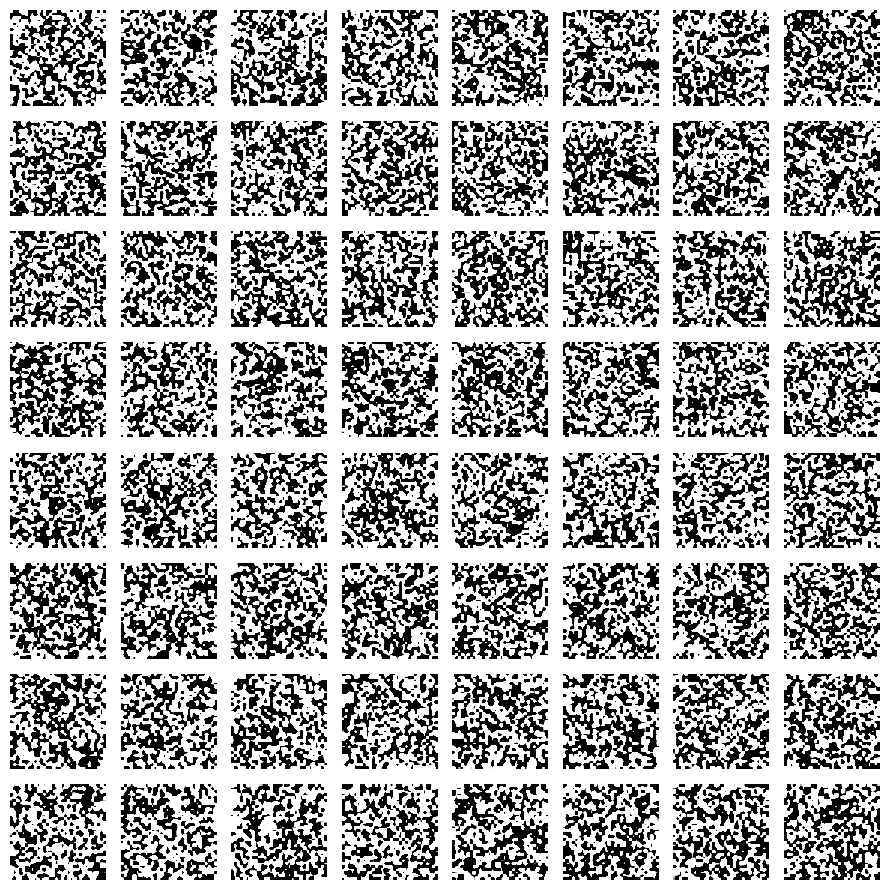

Epoch 421/427
117/117 [==============================] - 3s 22ms/step - loss: 33.8743 - val_loss: 44.4237
Epoch 422/427
117/117 [==============================] - 3s 22ms/step - loss: 33.6781 - val_loss: 29.2712
Epoch 423/427
117/117 [==============================] - 3s 22ms/step - loss: 36.3502 - val_loss: 31.7325
Epoch 424/427
117/117 [==============================] - 3s 22ms/step - loss: 33.2737 - val_loss: 46.2606
Epoch 425/427
117/117 [==============================] - 3s 22ms/step - loss: 36.2586 - val_loss: 39.7109
Epoch 426/427
117/117 [==============================] - 3s 22ms/step - loss: 34.4217 - val_loss: 36.3752
Epoch 427/427
117/117 [==============================] - 3s 22ms/step - loss: 36.9559 - val_loss: 33.8650


In [20]:
# Train the model
score_model.fit(train_data, validation_data=test_data, epochs=n_epochs, callbacks=[ImageGenCallback(20)])

In [27]:
# Create the directory for saving weights
import os
os.makedirs("weights", exist_ok=True)

In [25]:
# Save the model weights
score_model.save_weights("weights/weights_score_mnist_smoll.hdf5")

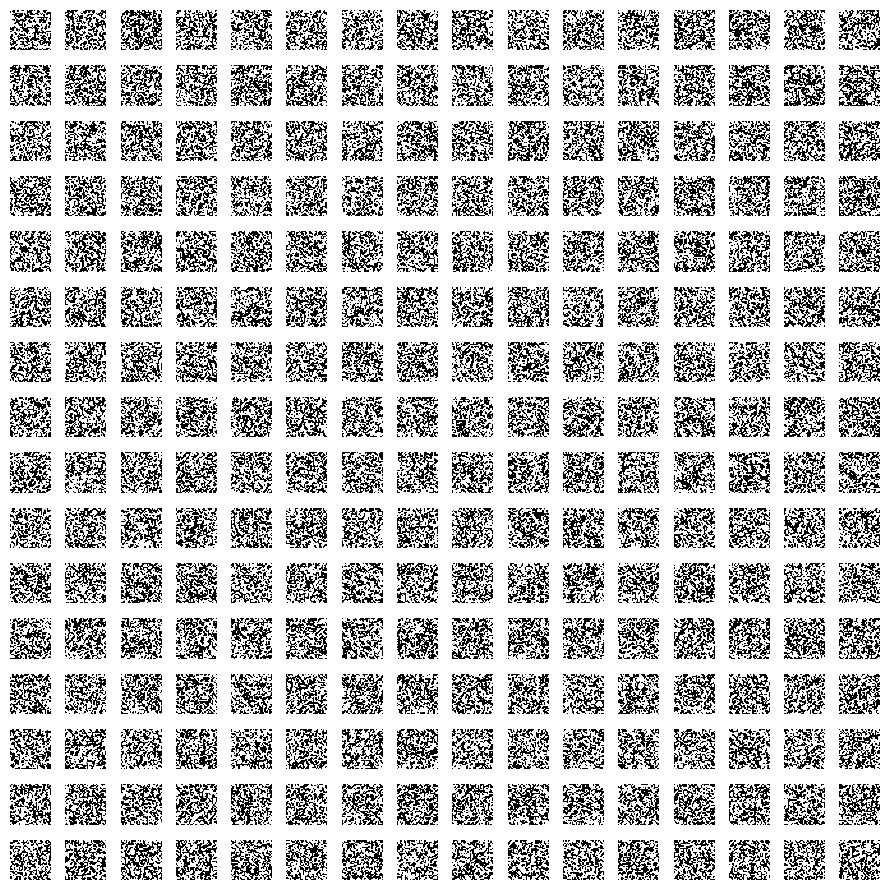

In [26]:
# Generate and plot final samples
gens = score_model.langevin_sampler(t_per_noise_scale, epsilon, n_samples=256)
plt.figure(figsize=(9,9))
for ind, image in enumerate(gens):
    plt.subplot(16, 16, ind+1)
    plt.imshow(image, vmin=0, vmax=1, cmap="Greys")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Inpainting, Interpolation, Creating Variations

In [32]:
# Define the ScoreMatching model
class ScoreMatching(tf.keras.Model):
    def __init__(self, inputs, outputs, noise_scales, **kwargs):
        super().__init__(inputs, outputs, **kwargs)
        self.loss_tracker = tf.keras.metrics.Mean("loss")
        self.num_noise_scales = len(noise_scales)
        self.noise_scales_tensor = tf.convert_to_tensor(noise_scales, dtype=tf.float32)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.denoising_score_matching_loss(data, training=True)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.denoising_score_matching_loss(data, training=False)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def denoising_score_matching_loss(self, image_batch, training=None):
        sampled_noise_index = tf.random.uniform([1], 0, self.num_noise_scales, dtype=tf.int32)[0]
        noise = self.noise_scales_tensor[sampled_noise_index]
        noisy_batch = image_batch + noise * tf.random.normal(tf.shape(image_batch))
        noise_input = tf.repeat(noise, tf.shape(noisy_batch)[0])[:, None, None, None]
        score = self([noisy_batch, noise_input], training=training)
        target_score = -1 / (noise**2) * (noisy_batch - image_batch)
        loss = tf.reduce_mean(0.5 * tf.reduce_sum((score - target_score)**2, axis=[1,2,3]))
        weight = noise**2
        return weight * loss

    @tf.function(jit_compile=True)
    def langevin_step(self, sample, alpha, noise, noise_input):
        sample = sample + alpha * self([sample, noise_input]) + tf.sqrt(2*alpha) * tf.random.normal(tf.shape(sample))
        return sample

    def langevin_sampler(self, n_steps, epsilon, n_samples=64, denoise=True, show_intermediate=False):
        sample = self.noise_scales_tensor[0] * tf.random.normal((n_samples,) + self.input_shape[0][1:])
        if show_intermediate:
            plt.figure(figsize=(9, 9))
            for ind, image in enumerate(sample):
                plt.subplot(8, 8, ind+1)
                plt.imshow(image, cmap="Greys")
                plt.axis("off")
            plt.suptitle("Initial samples")
            plt.show()
        for index, noise in enumerate(self.noise_scales_tensor):
            alpha = tf.cast(epsilon * (noise / self.noise_scales_tensor[-1])**2, tf.float32)
            noise_input = tf.repeat(noise, n_samples, axis=0)[:, None, None, None]
            for step in tf.range(n_steps):
                sample = self.langevin_step(sample, alpha, noise, noise_input)
            if show_intermediate and not index % show_intermediate:
                plt.figure(figsize=(9, 9))
                for ind, image in enumerate(sample):
                    plt.subplot(8, 8, ind+1)
                    plt.imshow(image, cmap="Greys", vmin=0, vmax=1)
                    plt.axis("off")
                plt.suptitle("Noise scale {}".format(noise))
                plt.show()
        if denoise:
            sample = sample + noise**2 * self([sample, noise_input]) / noise
        return sample

    def inpaint(self, masked_image, mask, n_steps, epsilon):
        sample = masked_image + self.noise_scales_tensor[0] * tf.random.normal(tf.shape(masked_image))
        for noise in self.noise_scales_tensor:
            alpha = tf.cast(epsilon * (noise / self.noise_scales_tensor[-1])**2, tf.float32)
            noise_input = tf.repeat(noise, tf.shape(sample)[0], axis=0)[:, None, None, None]
            for step in tf.range(n_steps):
                sample = self.langevin_step(sample, alpha, noise, noise_input)
                sample = mask * masked_image + (1 - mask) * sample
        return sample

    def interpolate(self, image1, image2, n_steps, epsilon, num_interpolations=10):
        alphas = np.linspace(0, 1, num_interpolations)
        samples = []
        for alpha in alphas:
            interpolated_image = alpha * image1 + (1 - alpha) * image2
            sample = interpolated_image + self.noise_scales_tensor[0] * tf.random.normal(tf.shape(interpolated_image))
            for noise in self.noise_scales_tensor:
                alpha = tf.cast(epsilon * (noise / self.noise_scales_tensor[-1])**2, tf.float32)
                noise_input = tf.repeat(noise, tf.shape(sample)[0], axis=0)[:, None, None, None]
                for step in tf.range(n_steps):
                    sample = self.langevin_step(sample, alpha, noise, noise_input)
            samples.append(sample)
        return samples

    def create_variations(self, image, start_noise_index, n_steps, epsilon):
        sample = image + self.noise_scales_tensor[start_noise_index] * tf.random.normal(tf.shape(image))
        for noise in self.noise_scales_tensor[start_noise_index:]:
            alpha = tf.cast(epsilon * (noise / self.noise_scales_tensor[-1])**2, tf.float32)
            noise_input = tf.repeat(noise, tf.shape(sample)[0], axis=0)[:, None, None, None]
            for step in tf.range(n_steps):
                sample = self.langevin_step(sample, alpha, noise, noise_input)
        return sample

In [34]:
score_model = ScoreMatching([inp, noise_input], score_output, noise_scales)

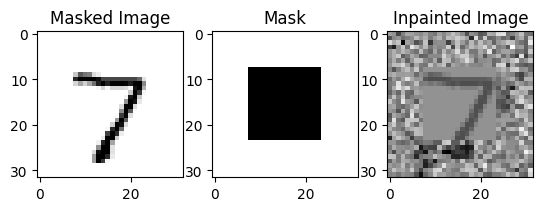

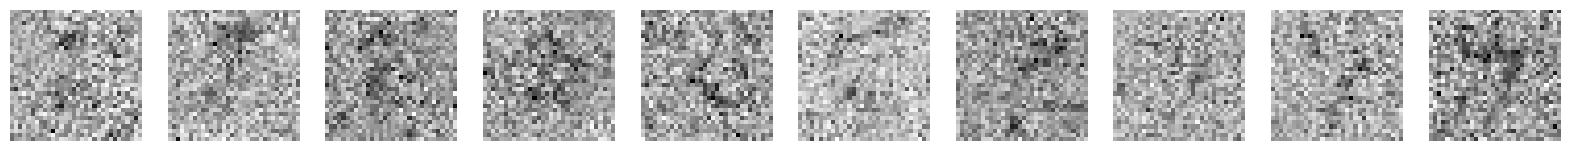

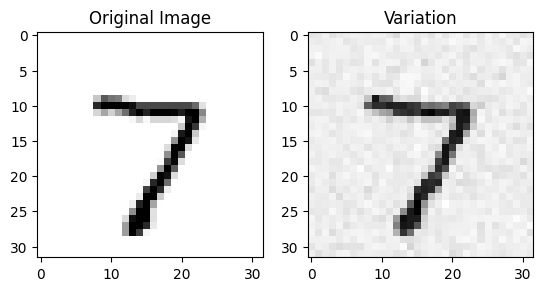

In [35]:
# Inpainting example
masked_image = test_images[:1]
mask = np.zeros_like(masked_image)
mask[:, 8:24, 8:24, :] = 1
inpainted_image = score_model.inpaint(masked_image, mask, t_per_noise_scale, epsilon)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(masked_image[0, :, :, 0], cmap="Greys")
plt.title("Masked Image")
plt.subplot(1, 3, 2)
plt.imshow(mask[0, :, :, 0], cmap="Greys")
plt.title("Mask")
plt.subplot(1, 3, 3)
plt.imshow(inpainted_image[0, :, :, 0], cmap="Greys")
plt.title("Inpainted Image")
plt.show()

# Interpolation example
image1 = test_images[0:1]
image2 = test_images[1:2]
interpolations = score_model.interpolate(image1, image2, t_per_noise_scale, epsilon, num_interpolations=10)
plt.figure(figsize=(20, 2))
for i, interp in enumerate(interpolations):
    plt.subplot(1, len(interpolations), i + 1)
    plt.imshow(interp[0, :, :, 0], cmap="Greys")
    plt.axis("off")
plt.show()

# Creating variations example
image = test_images[0:1]
start_noise_index = 5  # Intermediate noise level
variations = score_model.create_variations(image, start_noise_index, t_per_noise_scale, epsilon)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image[0, :, :, 0], cmap="Greys")
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(variations[0, :, :, 0], cmap="Greys")
plt.title("Variation")
plt.show()